# Monitoraggio Dati COVID-19 Italia

© Copyright 2020, Pietro Di Gangi

Raw data sources:
* COVID-19 data from Dipartimento della Protezione Civile: https://github.com/pcm-dpc/COVID-19
* Population data from  ISTAT (01/01/2019)

In [801]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [802]:
%run init.py

Current time: 2020-04-13 20:13:05.731773


In [803]:
#############################################
# Useful functions
#############################################
def sorted_set(regions, var):
    '''Ordina set rispetto alla variabile var'''
    df = data[data.region.isin(regions)][data.date==lastday].sort_values(var, ascending=False)
    sortedset = df.region.unique()
    return sortedset

def leglabels_style():
    '''Make legend labels colored'''
    leg._legend_box.align = "left"
    for line, text in zip(leg.get_lines(), leg.get_texts()):
        text.set_color(line.get_color())
        
def format_dateaxis():
    ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%-d %b %y'))
    fig.autofmt_xdate()
    plt.gcf().autofmt_xdate()

In [804]:
#############################################
# Read data from github repo: https://github.com/pcm-dpc/COVID-19
# Dipartimento della Protezione Civile
#############################################
url = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv'
path = 'dpc-covid19-ita-andamento-nazionale.csv'
ita = pd.read_csv(url)
url = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv'
regioni = pd.read_csv(url)
url = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-province/dpc-covid19-ita-province.csv'
prov = pd.read_csv(url)

#############################################
# Manipulate dataframes
#############################################
# Italia #################
ita = ita.rename(columns={
    'data': 'date',
    'totale_casi': 'cases',
    'deceduti' : 'deaths',
    'tamponi' : 'tests',
    'dimessi_guariti': 'recovered',
})
ita['region'] = 'Italia'
ita['date'] = ita['date'].map(lambda date: datetime.datetime.strptime(date, '%Y-%m-%dT%H:%M:%S'))


# Nord, Centro, Sud #################
nord = ['Lombardia', 'Emilia-Romagna', 'Friuli Venezia Giulia', 'Liguria', 'P.A. Bolzano', 'P.A. Trento', 'Piemonte', 'Valle d\'Aosta', 'Veneto']
centro = ['Abruzzo', 'Lazio', 'Marche', 'Molise', 'Toscana', 'Umbria']
sud = ['Basilicata', 'Calabria', 'Campania', 'Puglia', 'Sardegna', 'Sicilia']
def zone(region):
    if region in nord:
        return 'Nord'
    elif region in centro:
        return 'Centro'
    elif region in sud:
        return 'Sud'
    else: print('Error: No zone assigned to region!')


# Regioni #################
regioni = regioni.rename(columns={
    'data': 'date',
    'totale_casi': 'cases',
    'deceduti' : 'deaths',
    'denominazione_regione' : 'region',
    'tamponi' : 'tests',
    'dimessi_guariti': 'recovered'
})
regioni['date'] = regioni['date'].map(lambda date: datetime.datetime.strptime(date, '%Y-%m-%dT%H:%M:%S'))
regioni['zone'] = regioni['region'].map(lambda location: zone(location))
regioni = regioni.sort_values(['region', 'date'])

# Aree (Nord, Centro, Sud) #################
aree = regioni.groupby(['zone', 'date'],as_index=False).sum()
aree['region'] = aree['zone']

# merge dataframes #################
data = ita.append([aree, regioni], ignore_index=True)

# Dati popolazione ISTAT 01/01/2019
population = {
    'Lombardia': 10.04e6,
    'Emilia-Romagna': 4.45e6,
    'Veneto': 4.91e6,
    'Piemonte': 4.38e6,
    'Marche': 1.53e6,
    'Toscana': 3.74e6,
    'Liguria': 1.56e6,
    'Lazio': 5.90e6,
    'Campania': 5.83e6,
    'Friuli Venezia Giulia': 1.22e6,
    'P.A. Trento': 541e3,
    'P.A. Bolzano': 531e3,
    'Puglia': 4.05e6,
    'Abruzzo': 1.32e6,
    'Sicilia': 4999891,
    'Umbria': 885e3,
    'Sardegna': 1.65e6,
    'Valle d\'Aosta': 126e3,
    'Calabria': 1.96e6,
    'Basilicata': 567e3,
    'Molise': 308e3,
    'Nord': 27758000,
    'Centro': 13683000,
    'Sud': 19056891,
    'Italia': 60497891
}
# add population information
for region in population.keys():
    data.at[data.region==region, 'population'] = population[region]
data['population'] = data['population'].replace(np.nan, 9999999999)
data = data.replace(np.nan,0.0000000001)

# add differential data
for col in ['cases', 'recovered', 'deaths','tests','terapia_intensiva','totale_positivi','ricoverati_con_sintomi']:
    data['new_'+col] = data[col].diff()

data['new_terapia_intensiva_netta'] = data['new_terapia_intensiva'] + data['new_deaths'] + data['new_recovered']*data['terapia_intensiva'].shift(1)/data['ricoverati_con_sintomi'].shift(1)    

# add data per 100k inhabitants
for var in ['cases','new_cases','deaths','new_deaths','recovered','new_recovered','tests','new_tests','terapia_intensiva','new_terapia_intensiva','ricoverati_con_sintomi','new_ricoverati_con_sintomi']:
    data[var+'_per100k'] = data.apply(lambda row: row[var]/row.population*1e5, axis = 1)
    
# add tassi d'incremento 
def delta(data, variables):
    '''Tasso di crescita mediato sugli ultimi 1,2,3,4 giorni'''
    for var in variables: 
        for dayspan in [1,2,3,4]:
            colname = var+'_delta'+str(dayspan)
            data[colname] = 0
            for i in np.arange(dayspan):
                data[colname] = data[colname] + data['new_'+var].shift(i)/data[var].shift(i+1)
            data[colname] = data[colname]/dayspan    
    return data
data = delta(data, ['cases', 'deaths', 'recovered', 'tests'])

# cast some columns to int
data = data.replace(np.nan,0.0000000000)
data[['cases','new_cases','deaths','new_deaths','recovered','new_recovered','population','tests','new_tests','terapia_intensiva','new_terapia_intensiva']] = data[['cases','new_cases','deaths','new_deaths','recovered','new_recovered','population','tests','new_tests','terapia_intensiva','new_terapia_intensiva']].astype(int)

# ordering and casting/formatting columns   
data = data[['date','region','cases','new_cases','deaths','new_deaths','recovered','new_recovered','population',
             'tests','new_tests','terapia_intensiva','new_terapia_intensiva','new_terapia_intensiva_netta','totale_ospedalizzati','ricoverati_con_sintomi','new_ricoverati_con_sintomi','isolamento_domiciliare','totale_positivi','new_totale_positivi',
             'cases_per100k','new_cases_per100k','deaths_per100k','new_deaths_per100k','recovered_per100k','new_recovered_per100k',
             'tests_per100k','new_tests_per100k','terapia_intensiva_per100k','new_terapia_intensiva_per100k','ricoverati_con_sintomi_per100k','new_ricoverati_con_sintomi_per100k',
             'cases_delta1','cases_delta2','cases_delta3','cases_delta4',
             'deaths_delta1','deaths_delta2','deaths_delta3','deaths_delta4',
             'recovered_delta1','recovered_delta2','recovered_delta3','recovered_delta4',
             'tests_delta1','tests_delta2','tests_delta3','tests_delta4',
            ]]

data.to_pickle('dataframes/mydata_dpc_ita.p')

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


# Tabella Dati Nazionali e Regionali

In [805]:
lastday = data.date.iat[-1]
print('Dati aggiornati a:', lastday)

summary = data[data.date==lastday].sort_values('cases', ascending=False)
summary = summary[['region','cases','new_cases','deaths','new_deaths','terapia_intensiva','cases_per100k','deaths_per100k']]
summary['cases_per100k'] = summary['cases_per100k'].map('{:.1f}'.format)
summary['deaths_per100k'] = summary['deaths_per100k'].map('{:.1f}'.format)
summary.head(30)

Dati aggiornati a: 2020-04-13 17:00:00


region   cases  new_cases  deaths  new_deaths  \
49                   Italia  159516       3153   20465         566   
149                    Nord  126419       2535   17813         489   
649               Lombardia   60314       1262   10901         280   
99                   Centro   21529        410    1806          53   
449          Emilia-Romagna   20440        342    2615          51   
899                Piemonte   17134        474    1826          97   
1249                 Veneto   14251        174     882          26   
199                     Sud   11568        208     846          24   
1099                Toscana    7390        155     518          23   
599                 Liguria    5596        102     760          11   
699                  Marche    5381         78     713          13   
549                   Lazio    4968        123     284           5   
399                Campania    3670         66     248           6   
849             P.A. Trento    3126         73     300           7   
949                  Puglia    3065         76     267           7   
499   Friuli Venezia Giulia    2482         51     202           7   
1049                Sicilia    2458         42     171           8   
249                 Abruzzo    2213         53     224          12   
799            P.A. Bolzano    2149         51     212           7   
1149                 Umbria    1320          1      52           0   
999                Sardegna    1128         15      75           2   
349                Calabria     928          5      67           1   
1199          Valle d'Aosta     927          6     115           3   
299              Basilicata     319          4      18           0   
749                  Molise     257          0      15           0   

      terapia_intensiva cases_per100k deaths_per100k  
49                 3260         263.7           33.8  
149                2378         455.4           64.2  
649                1143         600.7          108.6  
99                  629         157.3           13.2  
449                 331         459.3           58.8  
899                 379         391.2           41.7  
1249                245         290.2           18.0  
199                 253          60.7            4.4  
1099                225         197.6           13.9  
599                 138         358.7           48.7  
699                 108         351.7           46.6  
549                 200          84.2            4.8  
399                  80          63.0            4.3  
849                  56         577.8           55.5  
949                  71          75.7            6.6  
499                  30         203.4           16.6  
1049                 51          49.2            3.4  
249                  54         167.7           17.0  
799                  41         404.7           39.9  
1149                 38         149.2            5.9  
999                  27          68.4            4.5  
349                  12          47.3            3.4  
1199                 15         735.7           91.3  
299                  12          56.3            3.2  
749                   4          83.4            4.9

# 1D Diagnostic Plots
Andamento delle singole variabili relative ai casi COVID-19 tramite grafici 1D.

## Valori normalizzati su popolazione: dati cumulati
Totale casi COVID-19 confermati per 100000 abitanti in Italia (Nord, Centro e Sud)
* Bars: i contributi delle singole aree sono sovrapposti

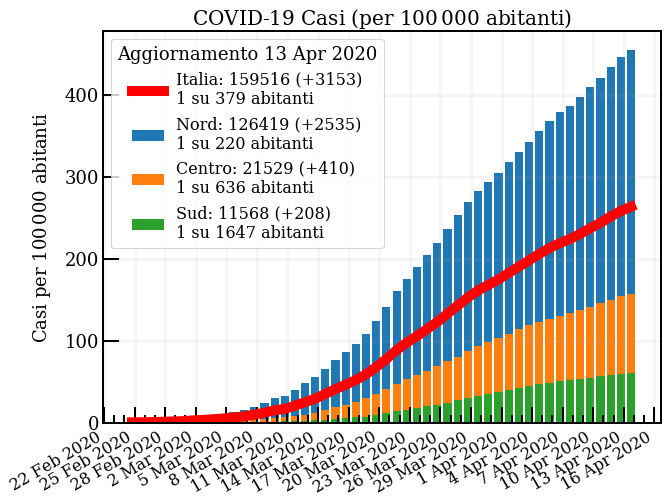

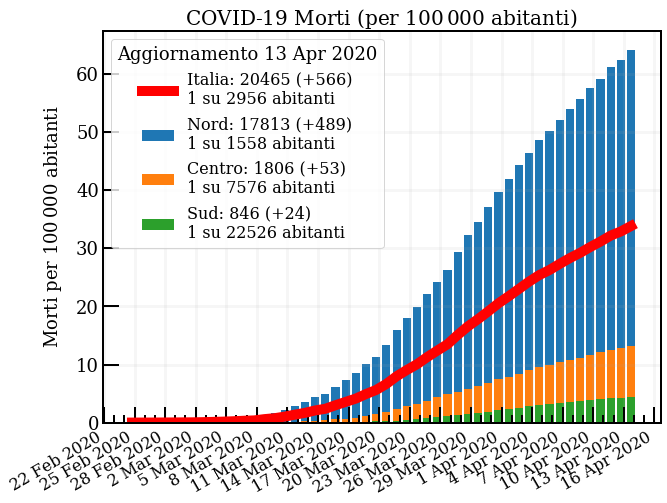

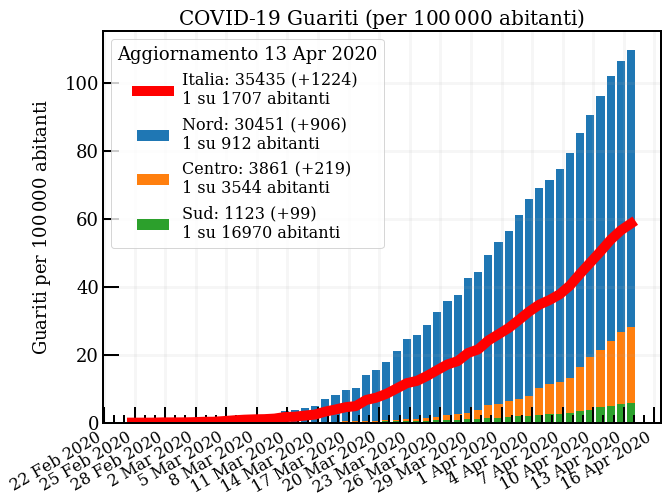

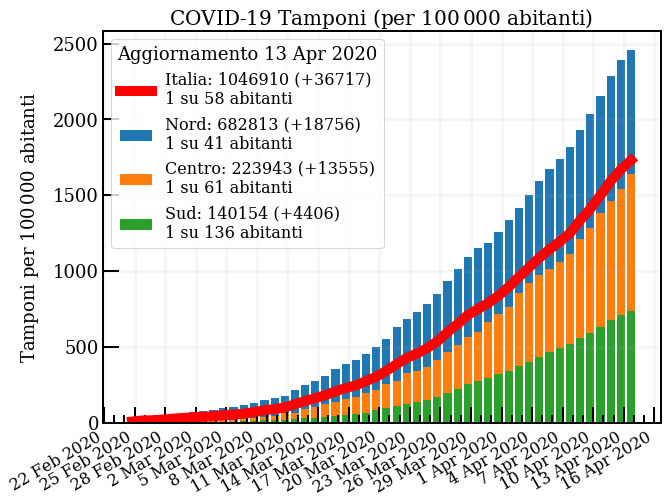

In [806]:
def cumulative_normalized(regions, var, title='', ylabel='y'):

    # figure
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)

    # selected sets
    N = len(regions)
    
    # plot data
    for i,reg in enumerate(regions):
        df = data[data.region==reg]
        pop = df['population'].iat[0]        
        tot = df[var].iat[-1]
        lb = '%s: %d (+%.f)' % (reg, tot, df['new_'+var].iat[-1])
        lb = lb + '\n1 su %.f abitanti' % (pop/tot)
        if reg=='Italia':
            ax.plot(df.date, df[var]/pop*1e5, label=lb, color='r', lw=10, ls='-')
        else:
            ax.bar(df.date, df[var]/pop*1e5, label=lb)

    # axes settings
    plt.ylabel(ylabel)
    plt.grid(axis='x', linewidth=3, alpha=0.1, which='major')
    plt.grid(axis='y', linewidth=3, alpha=0.1, which='both')
    ax.tick_params(axis='x', which='major', labelsize=16)
    ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%-d %b %Y'))
    fig.autofmt_xdate()
    plt.gcf().autofmt_xdate()
    
    #legend
    leg = plt.legend(loc='upper left',fontsize=16, title='Aggiornamento %s' % lastday.strftime('%-d %b %Y')) 
    plt.title(title, fontsize=20)
    
    plt.show()
    

regions = ['Nord', 'Centro', 'Sud','Italia']
cumulative_normalized(regions, 'cases', title='COVID-19 Casi (per 100$\,$000 abitanti)', ylabel='Casi per 100$\,$000 abitanti')
cumulative_normalized(regions, 'deaths', title='COVID-19 Morti (per 100$\,$000 abitanti)', ylabel='Morti per 100$\,$000 abitanti')
cumulative_normalized(regions, 'recovered', title='COVID-19 Guariti (per 100$\,$000 abitanti)', ylabel='Guariti per 100$\,$000 abitanti')
cumulative_normalized(regions, 'tests', title='COVID-19 Tamponi (per 100$\,$000 abitanti)', ylabel='Tamponi per 100$\,$000 abitanti')

## Valori normalizzati su popolazione: dati differenziali
Nuovi casi giornalieri COVID-19 per 100000 abitanti in Italia (Nord, Centro e Sud)

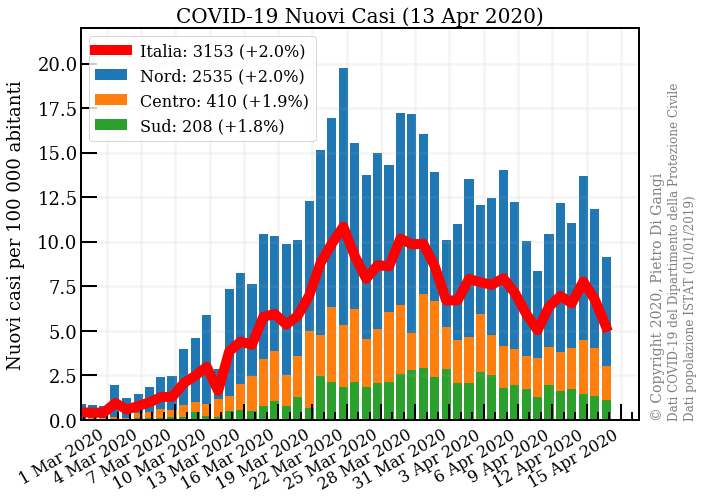

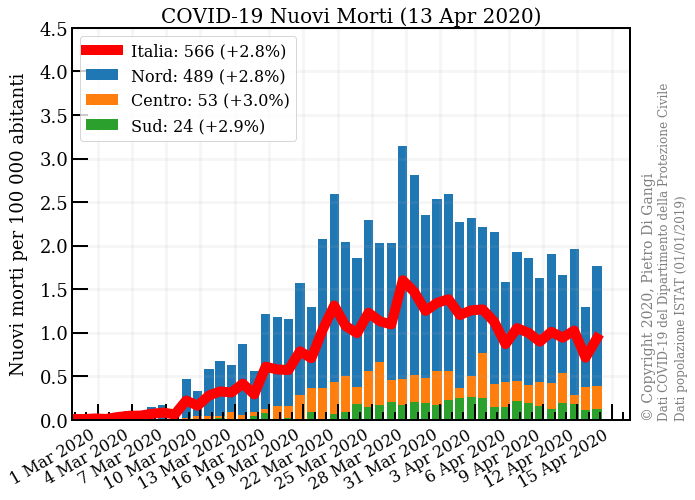

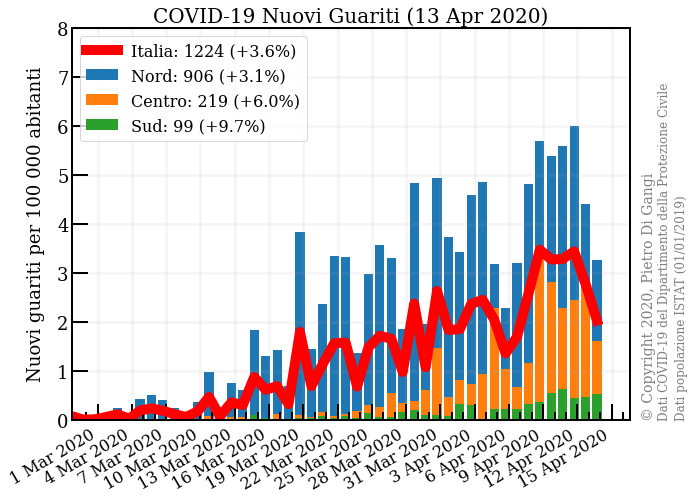

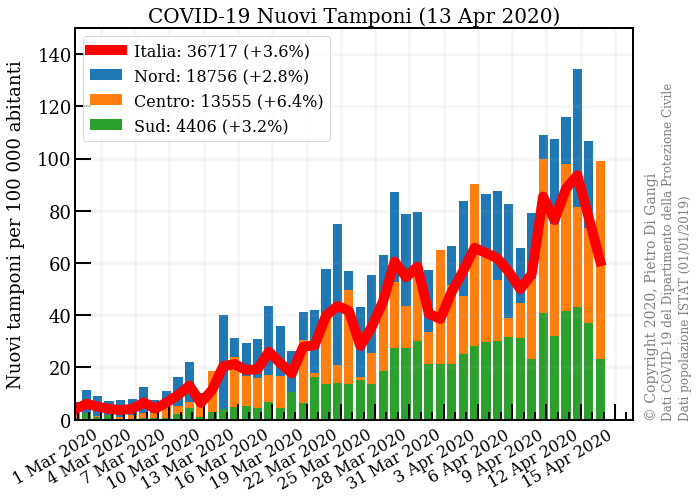

In [807]:
def differential_normalized(regions, var, title='', ylabel='y per 100 000 abitanti', ymax=100):
    cumvar = var.replace("new_", "")

    # figure
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)

    # selected sets
    N = len(regions)
    
    # plot data
    for i,reg in enumerate(regions):
        df = data[data.region==reg]
        pop = df['population'].iat[0]        
        tot = df[var].iat[-1]
        lb = '%s: %.f (+%.1f%s)' % (reg, tot, df[cumvar+'_delta1'].iat[-1]*100, '%')
        if reg=='Italia':
            ax.plot(df.date, df[var]/pop*1e5, label=lb, color='r', lw=10, ls='-')
        else:
            ax.bar(df.date, df[var]/pop*1e5, label=lb)

    # axes settings
    ax.set_xlim(left = df.date.iat[3])
    ax.set_ylim(0, ymax)
    plt.ylabel(ylabel)
    plt.grid(axis='x', linewidth=3, alpha=0.1, which='major')
    plt.grid(axis='y', linewidth=3, alpha=0.1, which='both')
    ax.tick_params(axis='x', which='major', labelsize=16)
    ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%-d %b %Y'))
    fig.autofmt_xdate()
    plt.gcf().autofmt_xdate()
    
    #legend
    leg = plt.legend(loc='upper left',fontsize=16) 
    plt.title(title + ' (%s)' % lastday.strftime('%-d %b %Y'), fontsize=20)
    
    # disclaimer
    dayspan = df.date.iat[-1] - df.date.iat[0]
    text = '© Copyright 2020, Pietro Di Gangi'
    plt.text(lastday+0.08*dayspan, 0, text, rotation=90, verticalalignment='bottom', color='grey', fontsize=14)
    text = 'Dati COVID-19 del Dipartimento della Protezione Civile'
    plt.text(lastday+0.11*dayspan, 0, text, rotation=90, verticalalignment='bottom', color='grey', fontsize=12)
    text = 'Dati popolazione ISTAT (01/01/2019)'
    plt.text(lastday+0.14*dayspan, 0, text, rotation=90, verticalalignment='bottom', color='grey', fontsize=12)
    
    plt.show()
    

regions = ['Nord', 'Centro', 'Sud','Italia']
differential_normalized(regions, 'new_cases', 
                                  title = 'COVID-19 Nuovi Casi', 
                                  ylabel = 'Nuovi casi per 100 000 abitanti',
                                  ymax = 22
                                 )

differential_normalized(regions, 'new_deaths', 
                                  title = 'COVID-19 Nuovi Morti', 
                                  ylabel = 'Nuovi morti per 100 000 abitanti',
                                  ymax = 4.5
                                 )

differential_normalized(regions, 'new_recovered', 
                                  title = 'COVID-19 Nuovi Guariti', 
                                  ylabel = 'Nuovi guariti per 100 000 abitanti',
                                  ymax = 8
                                 )

differential_normalized(regions, 'new_tests', 
                                  title = 'COVID-19 Nuovi Tamponi', 
                                  ylabel = 'Nuovi tamponi per 100 000 abitanti',
                                  ymax = 150
                                 )

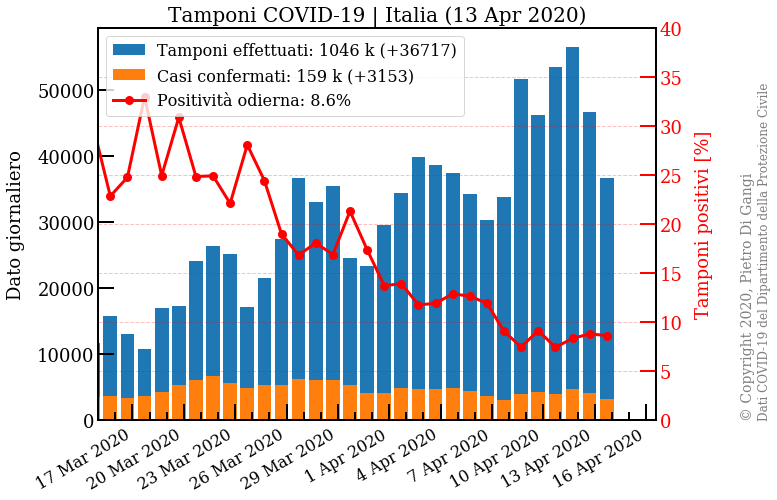

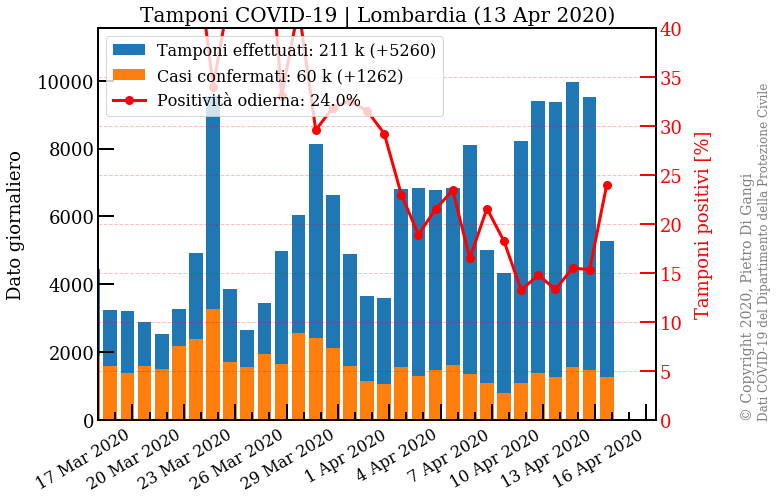

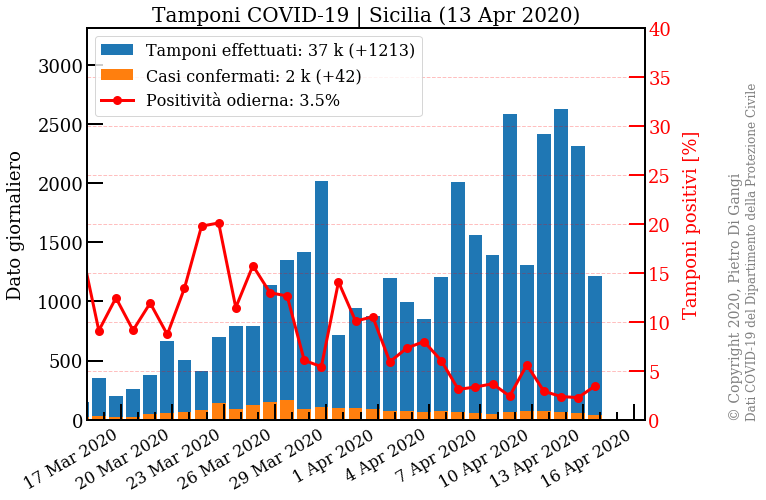

In [808]:
def positives_tests(region, title='', ylabel='y per 100 000 abitanti'):

    # figure
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)
    ax2 = ax.twinx()
    
    # plot data
    df = data[data.region==region]
    pop = df['population'].iat[0]  
    
    var = 'new_tests'
    cumvar = var.replace("new_", "")
    tot = df[var].iat[-1]
    lb1 = 'Tamponi effettuati: %d k (+%d)' % (df[cumvar].iat[-1]/1000, df[var].iat[-1])
    b1 = ax.bar(df.date, df[var], label=lb1)
    
    var = 'new_cases'
    cumvar = var.replace("new_", "")
    tot = df[var].iat[-1]
    lb2 = 'Casi confermati: %d k (+%d)' % (df[cumvar].iat[-1]/1000, df[var].iat[-1])
    b2 = ax.bar(df.date, df[var], label=lb2)
    
    lb3 = 'Positività odierna: %.1f%s' % (df['new_cases'].iat[-1]/df['new_tests'].iat[-1]*100, '%')
    l, = ax2.plot(df.date, df['new_cases']/df['new_tests']*100, label=lb3, color='r', marker='.', lw=3)

    # axes settings
    ax2.set_ylabel('Tamponi positivi [%]', color='r')
    ax2.tick_params(colors='r')
    ax2.set_yticks(np.arange(0,55,5))
    ax2.set_ylim(0,40)
    ax2.grid(axis='y', linewidth=1, alpha=0.25, color='r', ls='--', which='both')


    
    
    ax.set_xlim(datetime.datetime(2020,3,15))
    ax.set_ylim(bottom=0)
    ax.set_ylabel('Dato giornaliero')
    ax.tick_params(axis='x', which='major', labelsize=16)
    ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%-d %b %Y'))
    fig.autofmt_xdate()
    plt.gcf().autofmt_xdate()
    
    #legend
    handles = [b1, b2, l]
    labels = [lb1, lb2, lb3]
    plt.legend(handles, labels, loc='upper left')
    #leg = ax.legend(loc='upper left',fontsize=16) 
    plt.title(title + '%s (%s)' % (region,lastday.strftime('%-d %b %Y')), fontsize=20)
    
    # disclaimer
    dayspan = df.date.iat[-1] - df.date.iat[0]
    text = '© Copyright 2020, Pietro Di Gangi'
    plt.text(lastday+0.16*dayspan, 0, text, rotation=90, verticalalignment='bottom', color='grey', fontsize=14)
    text = 'Dati COVID-19 del Dipartimento della Protezione Civile'
    plt.text(lastday+0.18*dayspan, 0, text, rotation=90, verticalalignment='bottom', color='grey', fontsize=12)
    
    plt.show()
    

positives_tests('Italia', 'Tamponi COVID-19 | ')
positives_tests('Lombardia', 'Tamponi COVID-19 | ')
positives_tests('Sicilia', 'Tamponi COVID-19 | ')

## Valori assoluti: dati cumulati
Numero assoluto di casi COVID-19 confermati in Italia (Nord, Centro e Sud)
* Casi confermati
* Morti
* Guariti
* Tamponi effettuati

**Tipologia grafico**: Stacked bars - I contributi delle diverse aree sono impilati uno sopra l'altro

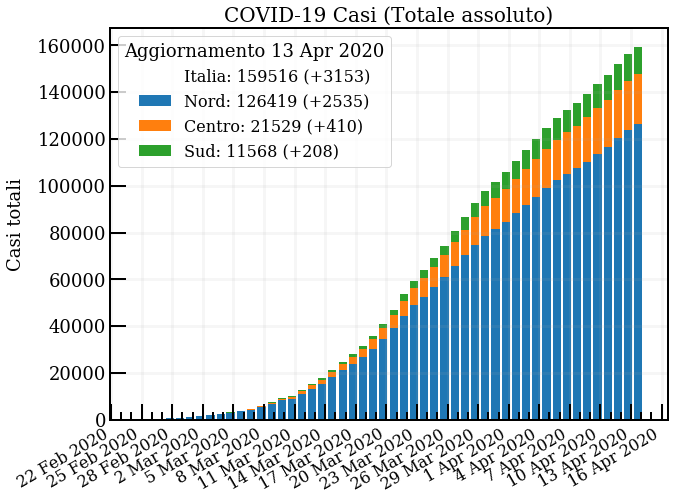

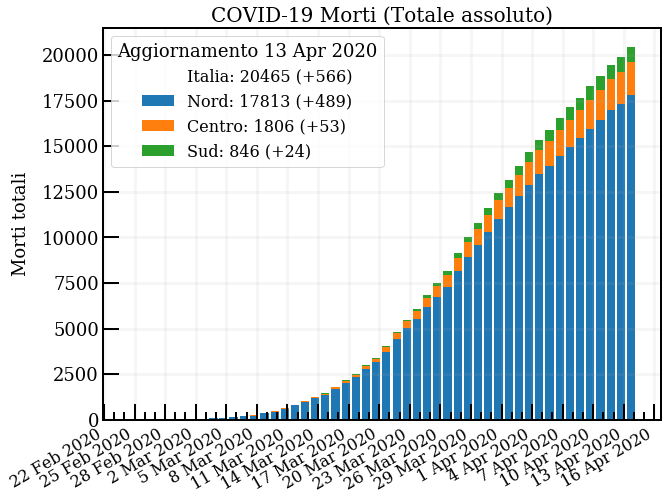

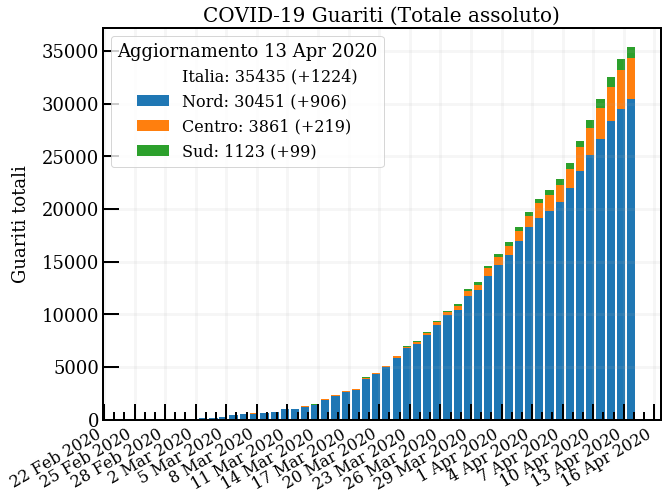

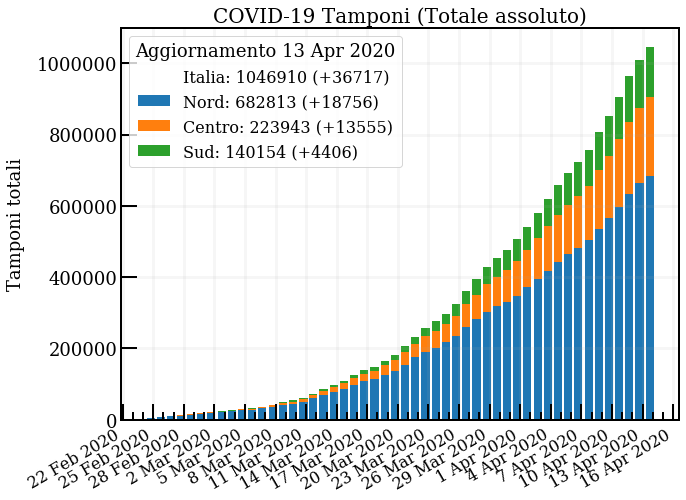

In [809]:
def cumulative(regions, colors, var, title='', ylabel='y'):

    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)

    regions = ['Nord', 'Centro', 'Sud']
    colors = ['tab:blue', "tab:orange","tab:green"]
    N = len(regions)

    df = data[data.region==regions[0]]
    margin_bottom = np.zeros(len(df['date'].drop_duplicates()))
    for i,reg in enumerate(regions):
        df = data[data.region==reg]
        tot = df[var].iat[-1]
        lb = '%s: %d (+%.f)' % (reg, tot, df['new_'+var].iat[-1])

        values = list(df[var])
        ax.bar(df.date, df[var], bottom=margin_bottom, label=lb)
        margin_bottom += values
    
    df = data[data.region=='Italia']
    lb = 'Italia: %d (+%.f)' % (df[var].iat[-1], df['new_'+var].iat[-1])
    ax.plot(df.date, df[var], label=lb, color='r', lw=5, ls='-', alpha=0)
    
    plt.ylabel(ylabel)
    plt.grid(axis='x', linewidth=3, alpha=0.1, which='major')
    plt.grid(axis='y', linewidth=3, alpha=0.1, which='both')
    ax.tick_params(axis='x', which='major', labelsize=16)
    
    ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%-d %b %Y'))
    fig.autofmt_xdate()
    plt.gcf().autofmt_xdate()
    
    #legend
    leg = plt.legend(loc='upper left',fontsize=16, title='Aggiornamento %s' % lastday.strftime('%-d %b %Y')) 
    plt.title(title, fontsize=20)
    
    plt.show()
    
regions = ['Nord', 'Centro', 'Sud']
colors = ['tab:blue', "tab:orange","tab:green"]    
cumulative(regions, colors, 'cases', title='COVID-19 Casi (Totale assoluto)', ylabel='Casi totali')
cumulative(regions, colors, 'deaths', title='COVID-19 Morti (Totale assoluto)', ylabel='Morti totali')
cumulative(regions, colors, 'recovered', title='COVID-19 Guariti (Totale assoluto)', ylabel='Guariti totali')
cumulative(regions, colors, 'tests', title='COVID-19 Tamponi (Totale assoluto)', ylabel='Tamponi totali')

## Valori assoluti: dati differenziali
Variazione assoluta giornaliera di casi COVID-19 in Italia (Nord, Centro e Sud).
* Stacked bars: i contributi delle diverse aree sono impilati uno sopra l'altro

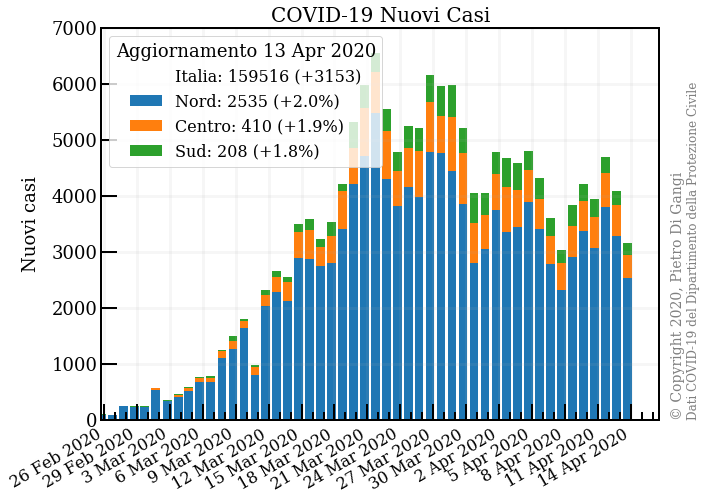

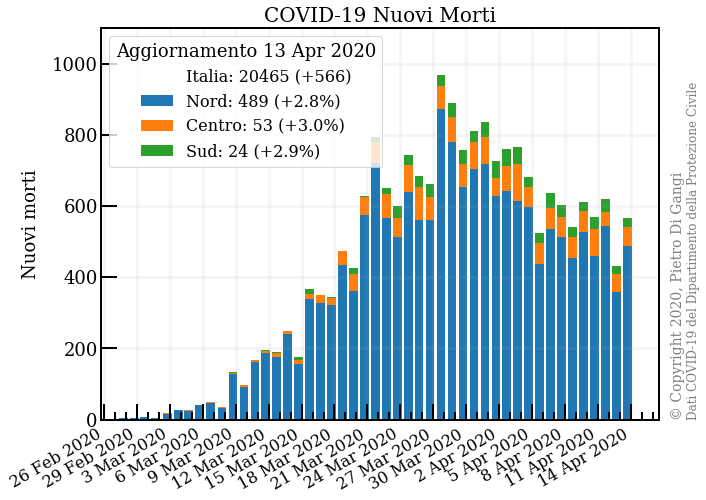

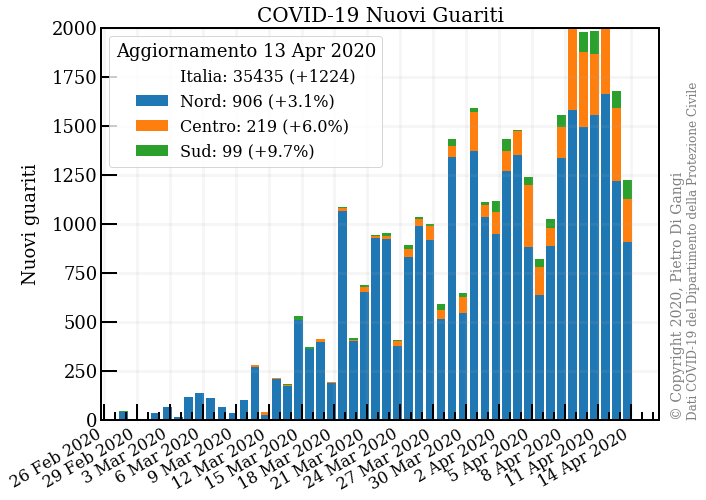

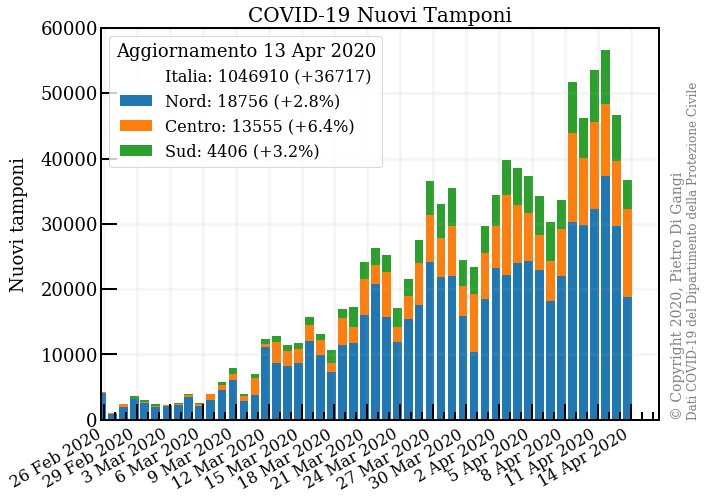

In [810]:
def differential(regions, var, title='', ylabel='y', ymax=100):
    cumvar = var.replace("new_", "")

    # figure
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)

    # selected sets
    N = len(regions)    
    
    # plot data
    df = data[data.region==regions[0]]
    margin_bottom = np.zeros(len(df['date'].drop_duplicates()))
    for i,reg in enumerate(regions):
        df = data[data.region==reg]
        tot = df[var].iat[-1]
        lb = '%s: %.f (+%.1f%s)' % (reg, tot, df[cumvar+'_delta1'].iat[-1]*100, '%')
        
        values = list(df[var])
        ax.bar(df.date, df[var], bottom=margin_bottom, label=lb)
        margin_bottom += values
    
    df = data[data.region=='Italia']
    lb = 'Italia: %d (+%.f)' % (df[cumvar].iat[-1], df[var].iat[-1])
    ax.plot(df.date, df[var], label=lb, color='r', lw=5, ls='-', alpha=0)

    # axes settings
    ax.set_xlim(left = df.date.iat[1])
    ax.set_ylim(0,ymax)
    plt.ylabel(ylabel)
    plt.grid(axis='x', linewidth=3, alpha=0.1, which='major')
    plt.grid(axis='y', linewidth=3, alpha=0.1, which='both')
    ax.tick_params(axis='x', which='major', labelsize=16)
    ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%-d %b %Y'))
    fig.autofmt_xdate()
    plt.gcf().autofmt_xdate()
    
    #legend
    leg = plt.legend(loc='upper left',fontsize=16, title='Aggiornamento %s' % lastday.strftime('%-d %b %Y')) 
    plt.title(title, fontsize=20)
    
    # disclaimer
    dayspan = df.date.iat[-1] - df.date.iat[0]
    text = '© Copyright 2020, Pietro Di Gangi'
    plt.text(lastday+0.08*dayspan, 0, text, rotation=90, verticalalignment='bottom', color='grey', fontsize=14)
    text = 'Dati COVID-19 del Dipartimento della Protezione Civile'
    plt.text(lastday+0.11*dayspan, 0, text, rotation=90, verticalalignment='bottom', color='grey', fontsize=12)
    
    plt.show()
    
regions = ['Nord', 'Centro', 'Sud']    
differential(regions, 'new_cases', 
                                  title = 'COVID-19 Nuovi Casi', 
                                  ylabel = 'Nuovi casi',
                                  ymax = 7000
                                 )

differential(regions, 'new_deaths', 
                                  title = 'COVID-19 Nuovi Morti', 
                                  ylabel = 'Nuovi morti',
                                  ymax = 1100
                                 )

differential(regions, 'new_recovered', 
                                  title = 'COVID-19 Nuovi Guariti', 
                                  ylabel = 'Nuovi guariti',
                                  ymax = 2000
                                 )

differential(regions, 'new_tests', 
                                  title = 'COVID-19 Nuovi Tamponi', 
                                  ylabel = 'Nuovi tamponi',
                                  ymax = 60000
                                 )

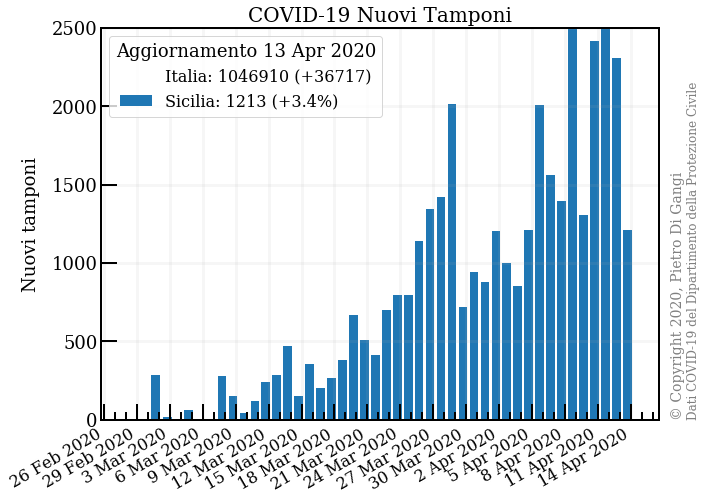

In [811]:
differential(['Sicilia'], 'new_tests', 
                                  title = 'COVID-19 Nuovi Tamponi', 
                                  ylabel = 'Nuovi tamponi',
                                  ymax = 2500
                                 )

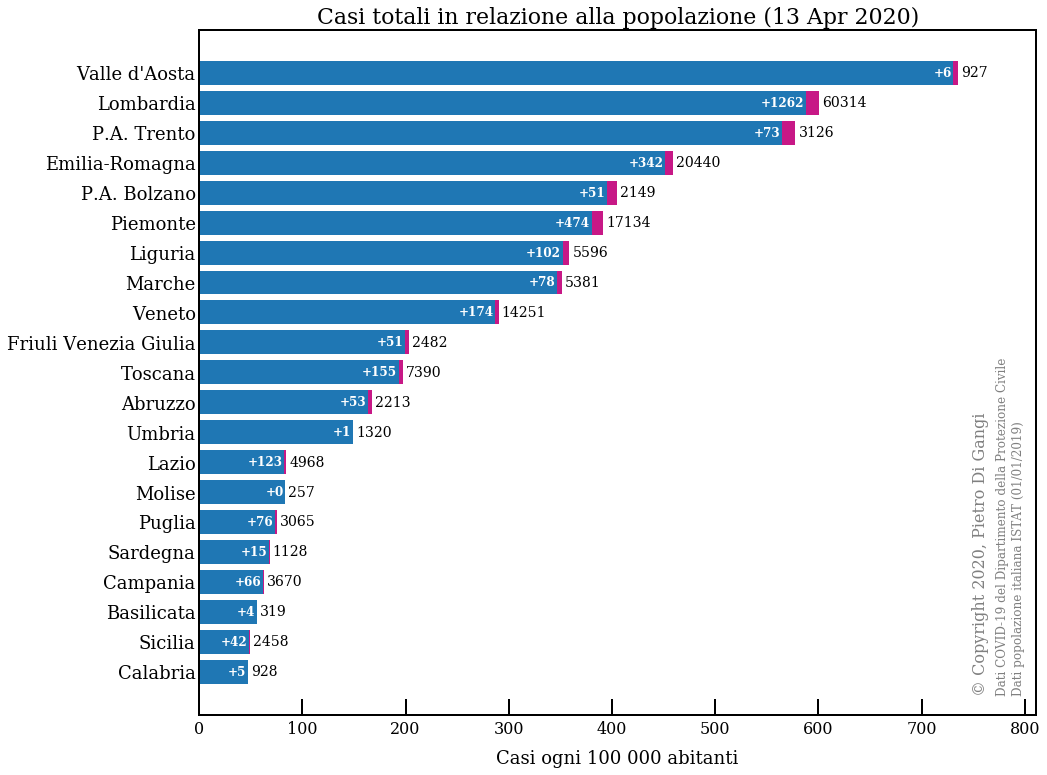

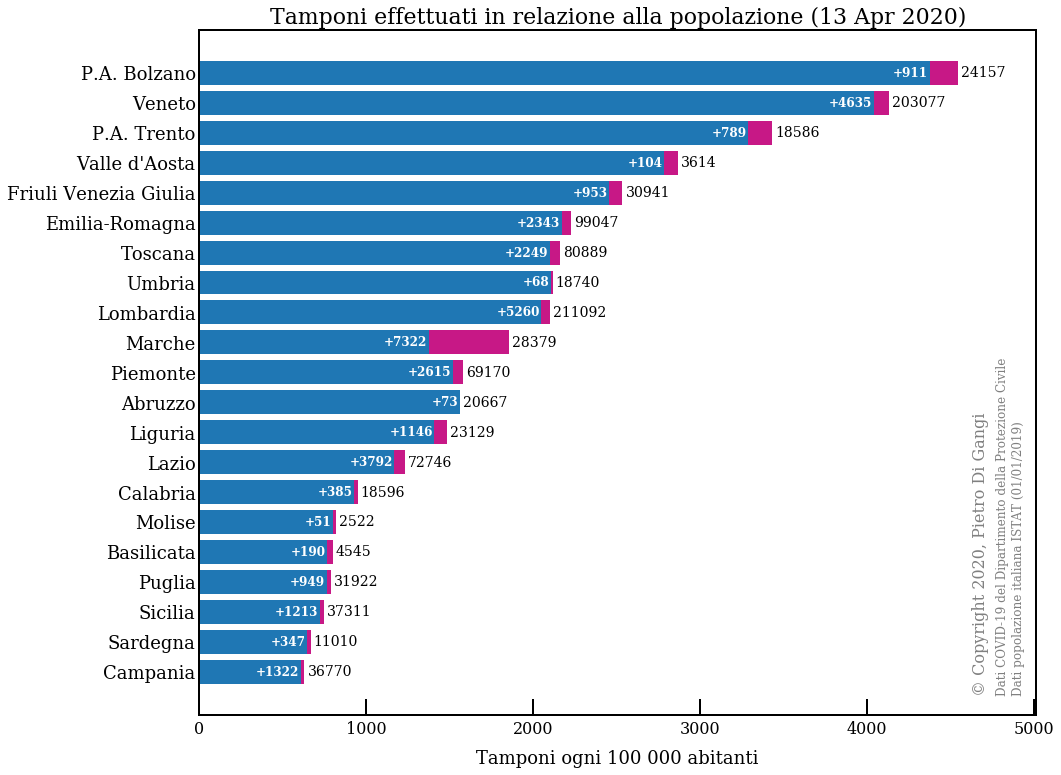

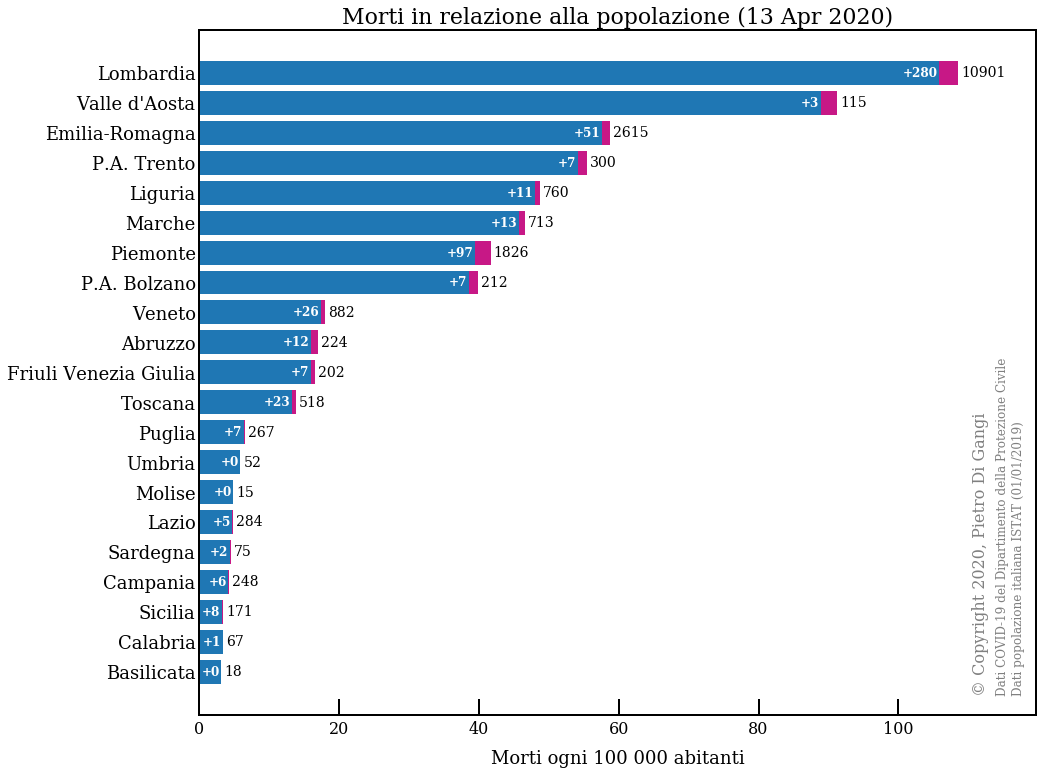

In [812]:
def standing_normalized(states, var, title='', xlabel='x'):

    n = len(states)*0.1
    
    fig = plt.figure(figsize=(15,6*n))
    ax = fig.add_subplot(111)
    ax.tick_params(left=False) 
    xmax = data[data.region==states[0]][var+'_per100k'].iat[-1]
    #states = sorted_states(states, var+'_per100k')
    states = states[::-1]
    
    for i,state in enumerate(states):
        df = data[data.region==state]
        pop = data.population.iat[0]
        tot = df[var].iat[-1]
        ax.barh(state, df[var+'_per100k'].iat[-1], color='mediumvioletred', label='', alpha=0.99)
        for days in np.arange(1):
            ax.barh(state, df[var+'_per100k'].iat[-2-days], color='tab:blue', label='', alpha=1)
        lb = '%d' % (tot)

        ax.text(df[var+'_per100k'].iat[-1]+2*xmax/500, state, lb, ha='left', va='center', fontsize=14)
        ax.text(df[var+'_per100k'].iat[-2]-1*xmax/500, state, ('+%d' % df['new_'+var].iat[-1]), ha='right', va='center', color='w', fontsize=12, weight='bold')
    
    plt.xlabel(xlabel)
    #ax.grid(axis='x', linewidth=2, alpha=0.1, which='major')
    ax.tick_params(axis='x', which='major', labelsize=16)
    
    xmin, xmax = ax.get_xlim() 
    ax.set_xlim(0,xmax*1.05)
    
    #legend
    plt.title(title+' (%s)' % lastday.strftime('%-d %b %Y'), fontsize=22)
    
    # disclaimer
    text = '© Copyright 2020, Pietro Di Gangi'
    plt.text(0.97*xmax, -0.8, text, rotation=90, verticalalignment='bottom', color='grey', fontsize=16)
    text = 'Dati COVID-19 del Dipartimento della Protezione Civile'
    plt.text(1.00*xmax, -0.8, text, rotation=90, verticalalignment='bottom', color='grey', fontsize=12)
    text = 'Dati popolazione italiana ISTAT (01/01/2019)'
    plt.text(1.02*xmax, -0.8, text, rotation=90, verticalalignment='bottom', color='grey', fontsize=12)

    plt.show()       

        
states = data[(data.region.isin(nord+centro+sud))&(data.date==lastday)].sort_values('cases_per100k', ascending=False).region.unique()
standing_normalized(states, 'cases', 'Casi totali in relazione alla popolazione', 'Casi ogni 100 000 abitanti')

states = data[(data.region.isin(nord+centro+sud))&(data.date==lastday)].sort_values('tests_per100k', ascending=False).region.unique()
standing_normalized(states, 'tests', 'Tamponi effettuati in relazione alla popolazione', 'Tamponi ogni 100 000 abitanti')

states = data[(data.region.isin(nord+centro+sud))&(data.date==lastday)].sort_values('deaths_per100k', ascending=False).region.unique()
standing_normalized(states, 'deaths', 'Morti in relazione alla popolazione', 'Morti ogni 100 000 abitanti')

# Overview COVID-19
Dati cumulati (valore accumulato fino ad oggi):
* Tamponi effettuati
* Casi confermati
* Dimessi guariti
* Morti

Dati attuali (valore registrato oggi):
* Attualmente positivi
* Ospedalizzati
* Ricoverati con sintomi
* In isolamento domiciliare
* In terapia intensiva

## Italia
Andamento e valori complessivi in Italia (Nord, Centro, Sud)

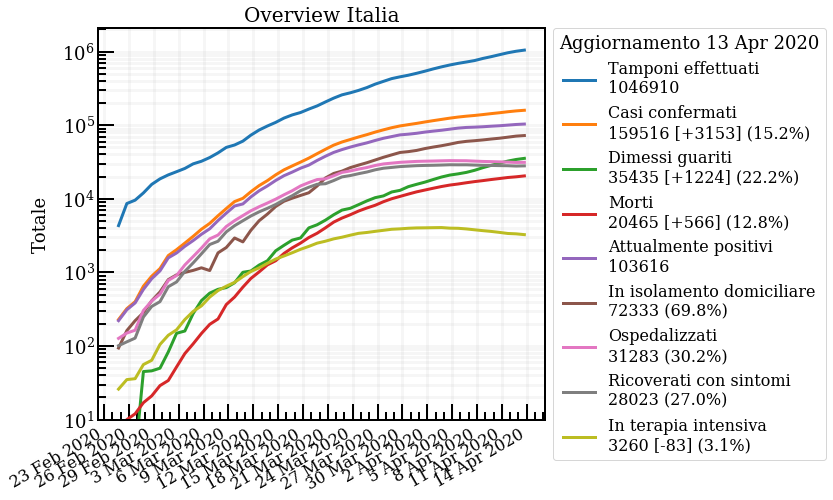

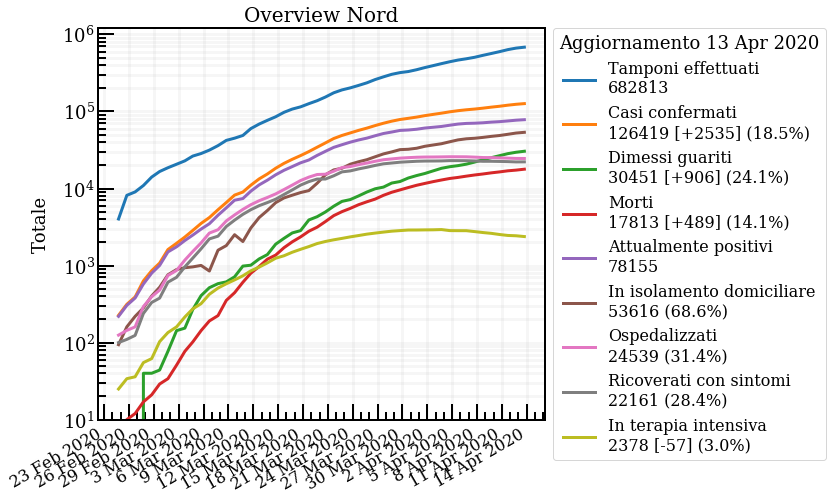

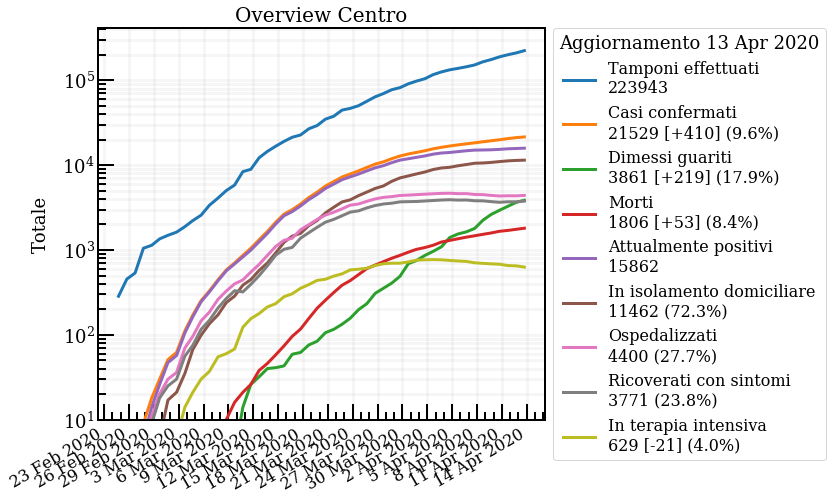

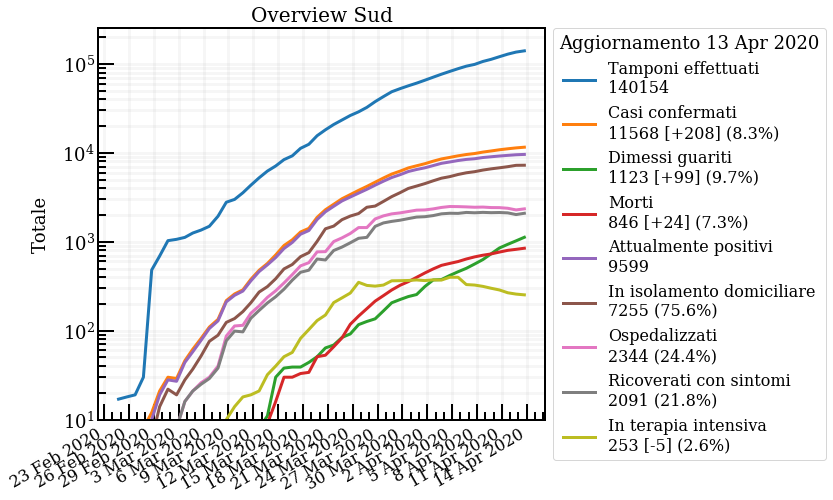

In [813]:
def overview(region, title=''):

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
   
    df = data[data.region==region]
    # dati cumulati
    ax.plot(df.date, df.tests, label='Tamponi effettuati\n%d' % df.tests.iat[-1])
    lb = 'Casi confermati\n%d [+%.f]' % (df.cases.iat[-1], df.new_cases.iat[-1])
    lb = lb + ' (%.1f%s)' % (df.cases.iat[-1]/df.tests.iat[-1]*100, '%')
    ax.plot(df.date, df.cases, label=lb)
    lb = 'Dimessi guariti\n%d [+%.f]' % (df.recovered.iat[-1], df.new_recovered.iat[-1])
    lb = lb + ' (%.1f%s)' % (df.recovered.iat[-1]/df.cases.iat[-1]*100, '%')
    ax.plot(df.date, df.recovered, label=lb)
    lb = 'Morti\n%d [+%.f]' % (df.deaths.iat[-1], df.new_deaths.iat[-1])
    lb = lb + ' (%.1f%s)' % (df.deaths.iat[-1]/df.cases.iat[-1]*100, '%')
    ax.plot(df.date, df.deaths, label=lb)
    
    # dati attuali
    ax.plot(df.date, df.totale_positivi, label='Attualmente positivi\n%d' % df.totale_positivi.iat[-1])
    tot = df.isolamento_domiciliare.iat[-1]
    pc = tot/df.totale_positivi.iat[-1]
    ax.plot(df.date, df.isolamento_domiciliare, label='In isolamento domiciliare\n%d (%.1f%s)' % (tot, pc*100, '%'))
    tot = df.totale_ospedalizzati.iat[-1]
    pc = tot/df.totale_positivi.iat[-1]
    ax.plot(df.date, df.totale_ospedalizzati, label='Ospedalizzati\n%d (%.1f%s)' % (tot, pc*100, '%'))
    tot = df.ricoverati_con_sintomi.iat[-1]
    pc = tot/df.totale_positivi.iat[-1]
    ax.plot(df.date, df.ricoverati_con_sintomi, label='Ricoverati con sintomi\n%d (%.1f%s)' % (tot, pc*100, '%'))
    tot = df.terapia_intensiva.iat[-1]
    pc = tot/df.totale_positivi.iat[-1]
    new = df.new_terapia_intensiva.iat[-1]
    ax.plot(df.date, df.terapia_intensiva, label='In terapia intensiva\n%d [%.f] (%.1f%s)' % (tot, new, pc*100, '%'))
    
    plt.ylabel('Totale')
    plt.yscale('log')
    ax.set_ylim(bottom=10)
    plt.grid(axis='x', linewidth=3, alpha=0.1, which='major')
    plt.grid(axis='y', linewidth=3, alpha=0.1, which='both')
    ax.tick_params(axis='x', which='major', labelsize=16)
    
    ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%-d %b %Y'))
    fig.autofmt_xdate()
    plt.gcf().autofmt_xdate()
    
    #legend
    leg = plt.legend(loc='upper left',fontsize=16, bbox_to_anchor=(1.,1.02), title='Aggiornamento %s' % lastday.strftime('%-d %b %Y')) 
    plt.title(title, fontsize=20)
    
    plt.show()
    

regions = ['Nord', 'Centro', 'Sud']
overview('Italia', 'Overview Italia')
for area in ['Nord', 'Centro', 'Sud']:
    overview(area, 'Overview '+area)

## Evoluzione giornaliera della situazione ospedaliera
Aumento giornaliero di:
* Casi confermati
* Morti
* Dimessi guariti
* Nuovi ricoveri in terapia intensiva (TI) *

Variazione giornaliera di:
* Persone attualmente positive
* Persone ricoverate in ospedale
* Persone ricoverate in terapia intensiva

(*) I nuovi ingressi giornalieri in terapia intensiva sono stimati sulla base della variazione di posti di TI attualmente occupati, morti e guariti. In questo modo si tiene conto dei posti di TI liberati ogni giorno, stimati sotto le seguenti assunzioni:
* Posto di TI liberato per morte - I morti di oggi si trovavano in terapia intensiva il giorno precedente
* Posto di TI liberato per guarigione - Fra i dimessi guariti di oggi, una frazione uguale a ricoveri_terapia_intensiva/ricoveri (riscontrata il giorno precedente) era ricoverata in terapia intensiva


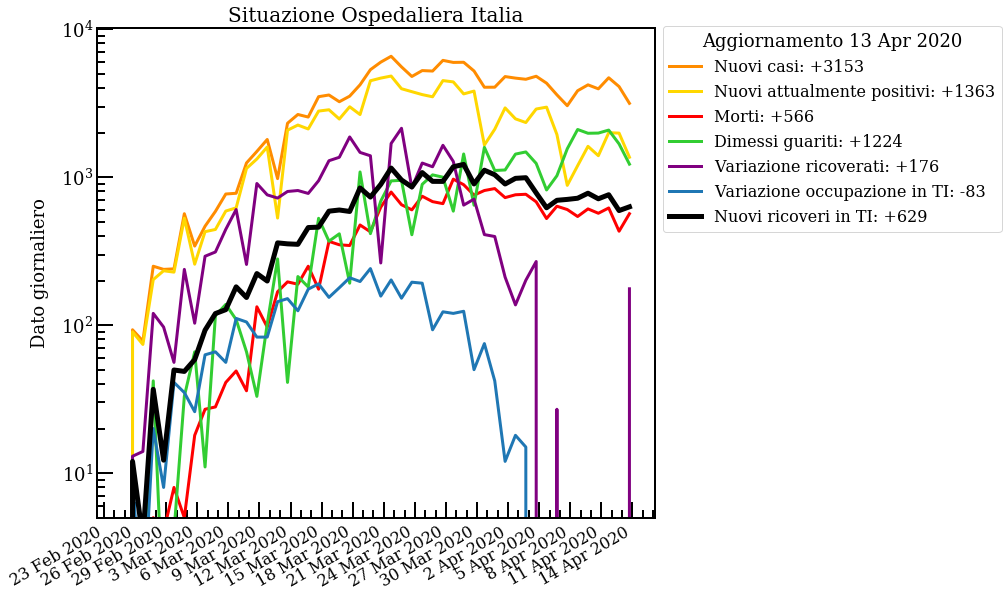

In [814]:
def malati(region, title=''):

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
   
    df = data[data.region==region]
    
    ax.plot(df.date, df.new_cases, color='darkorange', label='Nuovi casi: +%d' % df.new_cases.iat[-1])
    ax.plot(df.date, df.new_totale_positivi, color='gold', label='Nuovi attualmente positivi: +%d' % df.new_totale_positivi.iat[-1])
    ax.plot(df.date, df.new_deaths, color='r', label='Morti: +%d' % df.new_deaths.iat[-1])
    ax.plot(df.date, df.new_recovered, color='limegreen', label='Dimessi guariti: +%d' % df.new_recovered.iat[-1])
    ax.plot(df.date, df.new_ricoverati_con_sintomi, color='purple', label='Variazione ricoverati: +%d' % df.new_ricoverati_con_sintomi.iat[-1])
    if df.new_terapia_intensiva.iat[-1]<0: sign=''
    else: sign='+'
    ax.plot(df.date, df.new_terapia_intensiva, color='tab:blue', label='Variazione occupazione in TI: %s%d' % (sign,df.new_terapia_intensiva.iat[-1]))
    ax.plot(df.date, df.new_terapia_intensiva_netta, lw=5, ls='-', color='k', label='Nuovi ricoveri in TI: +%d' % df.new_terapia_intensiva_netta.iat[-1])

    
    plt.ylabel('Dato giornaliero')
    plt.yscale('log')
    ax.set_ylim(bottom=5)
    ax.tick_params(axis='x', which='major', labelsize=16)
    
    ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%-d %b %Y'))
    fig.autofmt_xdate()
    plt.gcf().autofmt_xdate()
    
    #legend
    leg = plt.legend(loc='upper left', bbox_to_anchor=(1,1.02), fontsize=16, title='Aggiornamento %s' % lastday.strftime('%-d %b %Y')) 
    plt.title(title, fontsize=20)
    
    plt.show()
    

malati('Italia', 'Situazione Ospedaliera Italia')

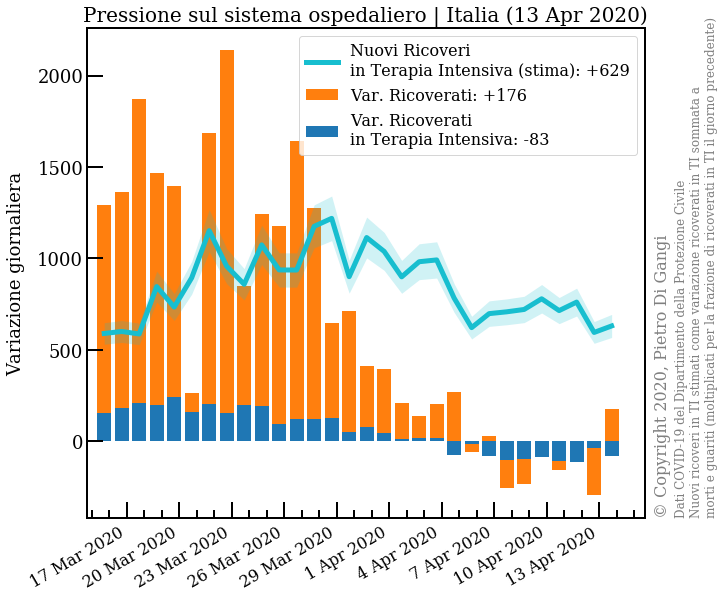

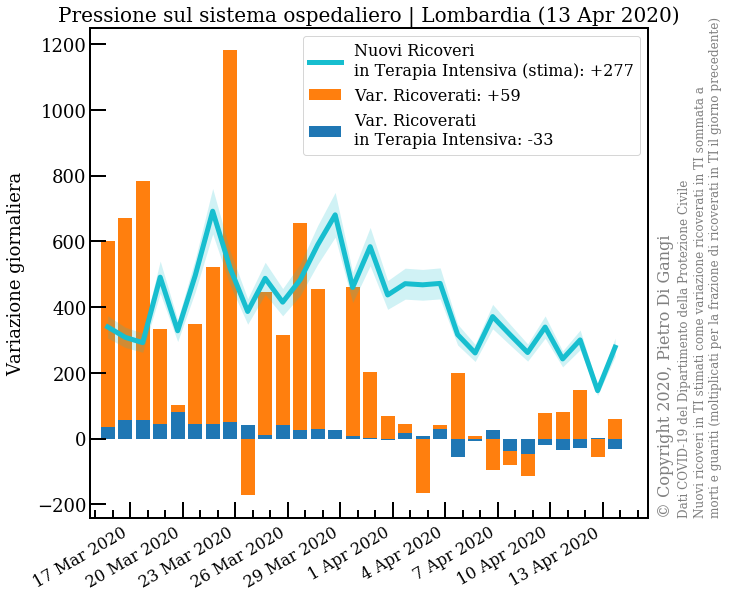

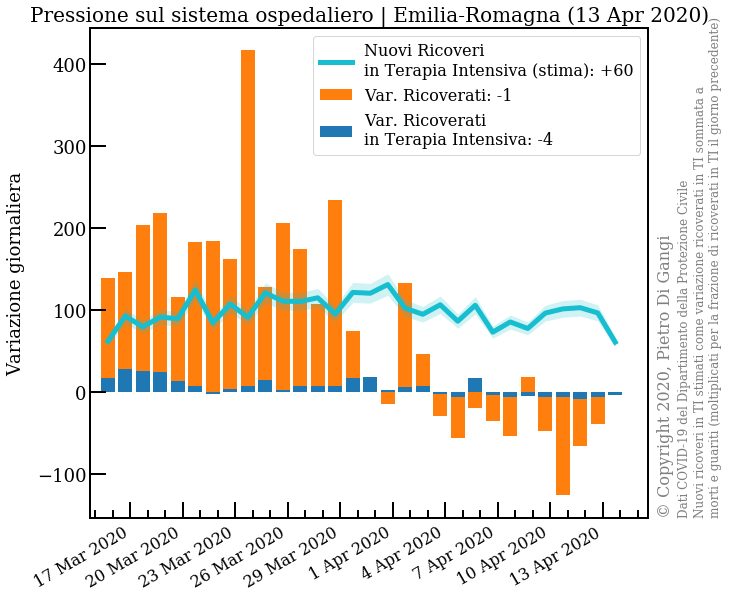

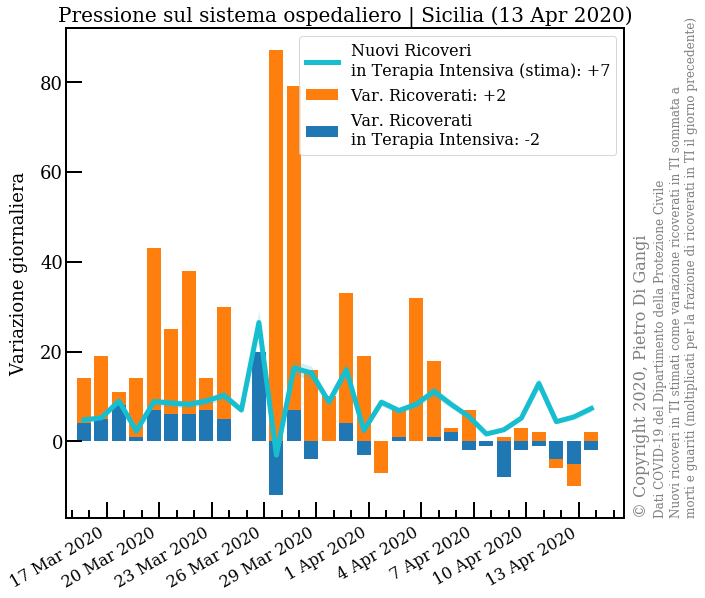

In [815]:
def icu(region, title='', dayspan=30):

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
   
    df = data[data.region==region]
    df = df[df.date > lastday-timedelta(dayspan)]
    
    #ax.plot(df.date, df.new_cases, color='darkorange', label='Nuovi casi: +%d' % df.new_cases.iat[-1])
    #ax.plot(df.date, df.new_totale_positivi, color='gold', label='Nuovi attualmente positivi: +%d' % df.new_totale_positivi.iat[-1])
    #ax.plot(df.date, df.new_deaths, color='r', label='Morti: +%d' % df.new_deaths.iat[-1])
    #ax.plot(df.date, df.new_recovered, color='limegreen', label='Dimessi guariti: +%d' % df.new_recovered.iat[-1])
    if df.new_ricoverati_con_sintomi.iat[-1]<0: sign=''
    else: sign='+'
    ax.bar(df.date, df.new_ricoverati_con_sintomi, color='tab:orange', label='Var. Ricoverati: %s%d' % (sign,df.new_ricoverati_con_sintomi.iat[-1]))
        
    if df.new_terapia_intensiva.iat[-1]<0: sign=''
    else: sign='+'
    ax.bar(df.date, df.new_terapia_intensiva, color='tab:blue', label='Var. Ricoverati\nin Terapia Intensiva: %s%d' % (sign,df.new_terapia_intensiva.iat[-1]))

    ax.plot(df.date, df.new_terapia_intensiva_netta, color='tab:cyan', lw=5, label='Nuovi Ricoveri\nin Terapia Intensiva (stima): +%d' % df.new_terapia_intensiva_netta.iat[-1])
    ax.fill_between(df.date, df.new_terapia_intensiva_netta*1.1, df.new_terapia_intensiva_netta, lw=0, alpha=0.2, color='tab:cyan', zorder=100)
    ax.fill_between(df.date, df.new_terapia_intensiva_netta*0.9, df.new_terapia_intensiva_netta, lw=0, alpha=0.2, color='tab:cyan', zorder=100)

    
    plt.ylabel('Variazione giornaliera')
    #plt.yscale('log')
    ax.set_ylim()
    ax.set_xlim(left=lastday-timedelta(days=dayspan))
    ax.tick_params(axis='x', which='major', labelsize=16)
    
    ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%-d %b %Y'))
    fig.autofmt_xdate()
    plt.gcf().autofmt_xdate()
    
    #legend
    leg = plt.legend(loc=0, fontsize=16) 
    plt.title(title + ' (%s)' % lastday.strftime('%-d %b %Y'), fontsize=20)
    
    # disclaimer
    xlim = timedelta(days=dayspan)
    ylim = ax.get_ylim()
    text = '© Copyright 2020, Pietro Di Gangi'
    plt.text(lastday+timedelta(0)+0.08*xlim, ylim[0], text, rotation=90, verticalalignment='bottom', color='grey', fontsize=16)
    text = 'Dati COVID-19 del Dipartimento della Protezione Civile'
    plt.text(lastday+timedelta(0)+0.12*xlim, ylim[0], text, rotation=90, verticalalignment='bottom', color='grey', fontsize=12)
    text = 'Nuovi ricoveri in TI stimati come variazione ricoverati in TI sommata a\nmorti e guariti (moltiplicati per la frazione di ricoverati in TI il giorno precedente)'
    plt.text(lastday+timedelta(0)+0.15*xlim, ylim[0], text, rotation=90, verticalalignment='bottom', color='grey', fontsize=12)

    plt.show()
    

icu('Italia', 'Pressione sul sistema ospedaliero | Italia')
icu('Lombardia', 'Pressione sul sistema ospedaliero | Lombardia')
icu('Emilia-Romagna', 'Pressione sul sistema ospedaliero | Emilia-Romagna')
icu('Sicilia', 'Pressione sul sistema ospedaliero | Sicilia')

## Regioni
Andamento e valori complessivi nelle singole regioni

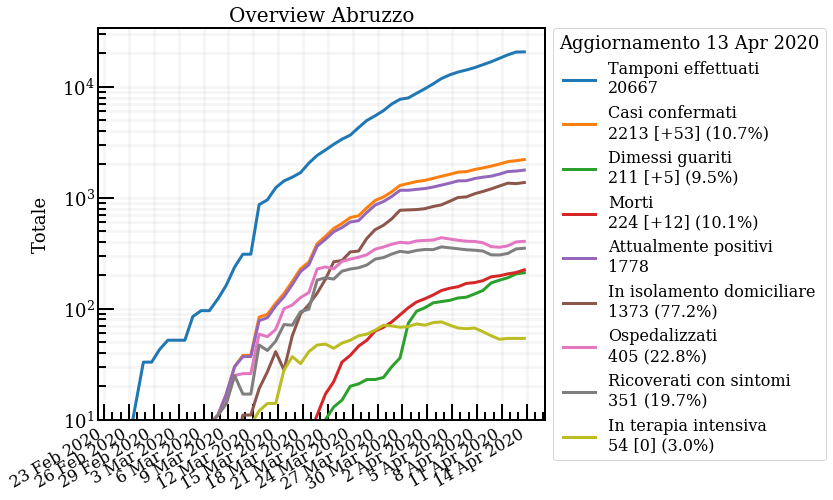

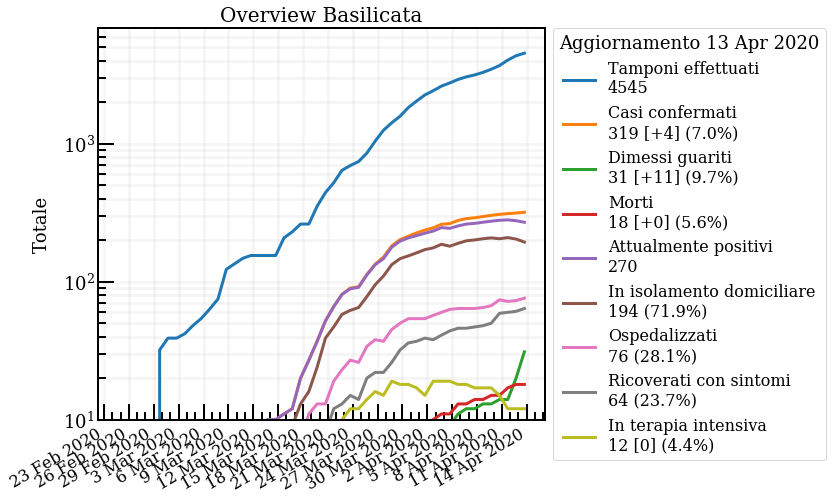

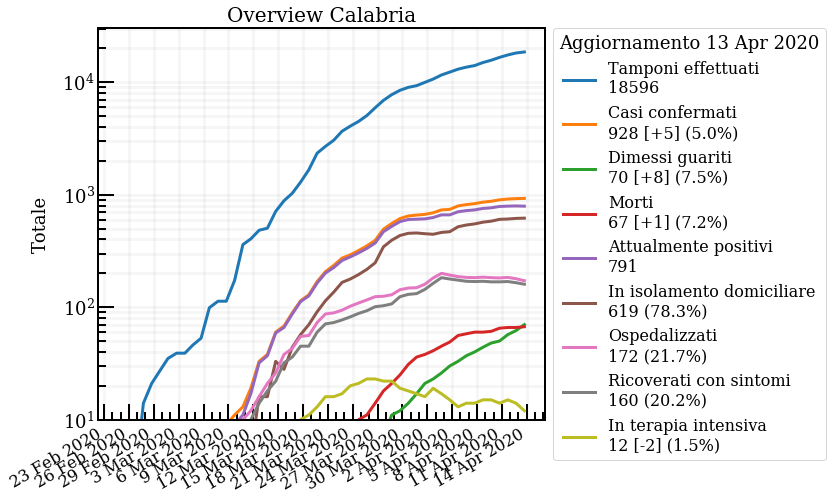

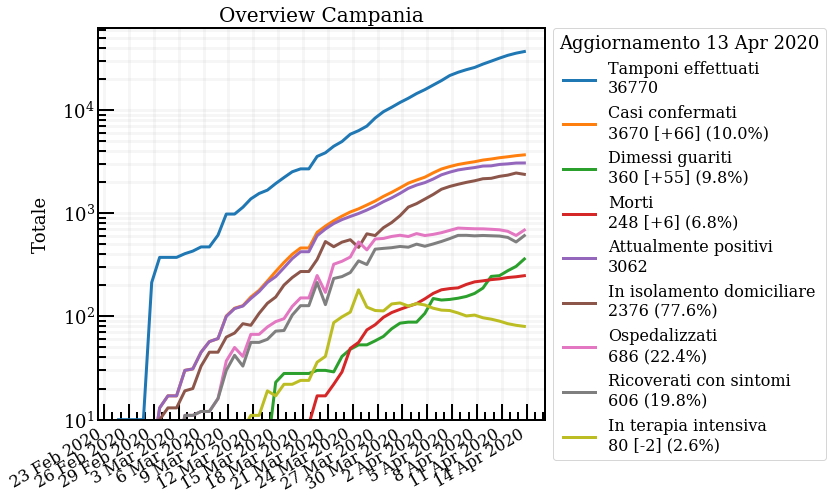

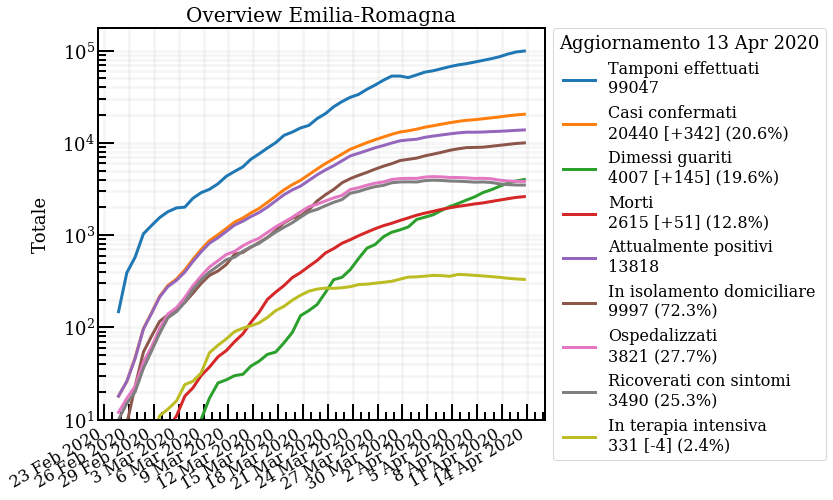

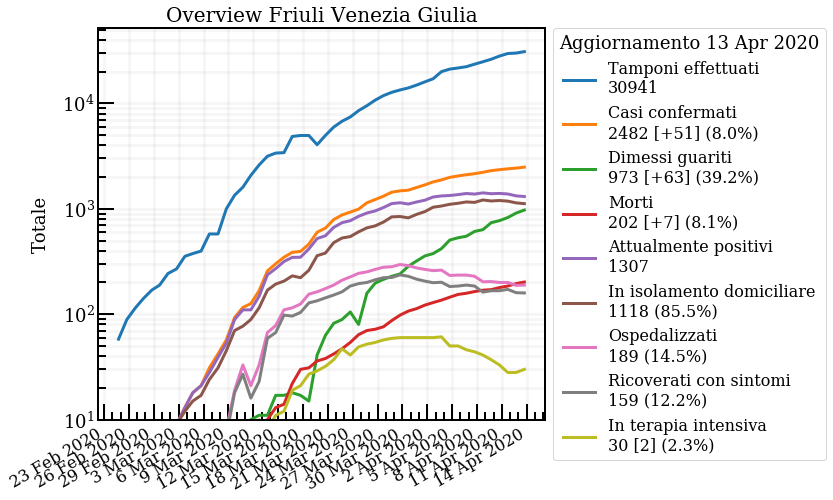

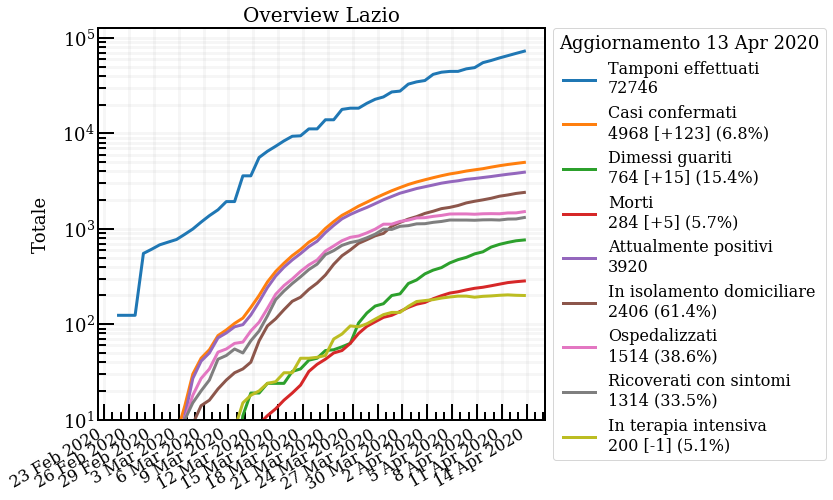

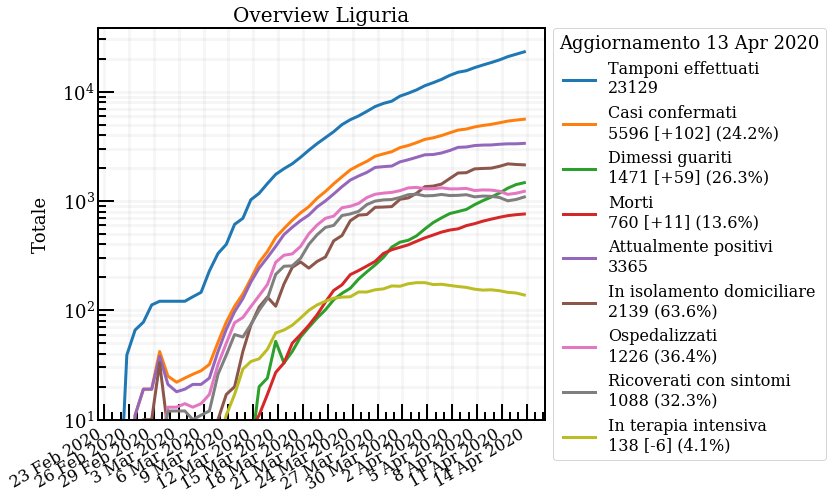

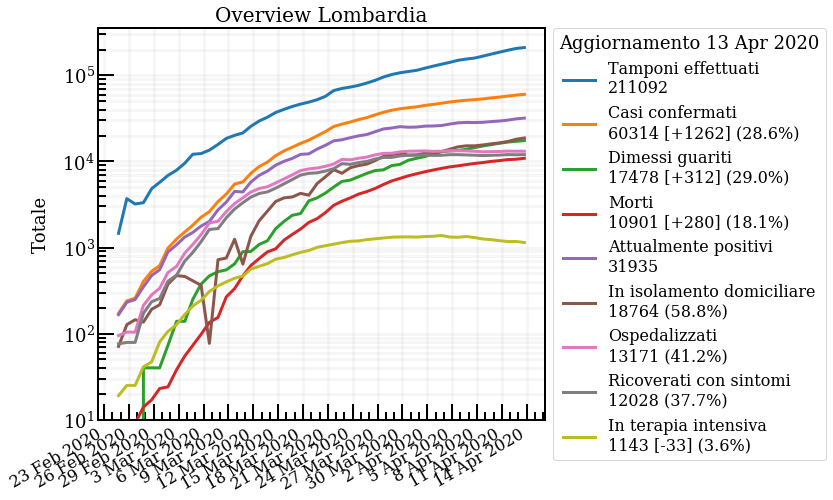

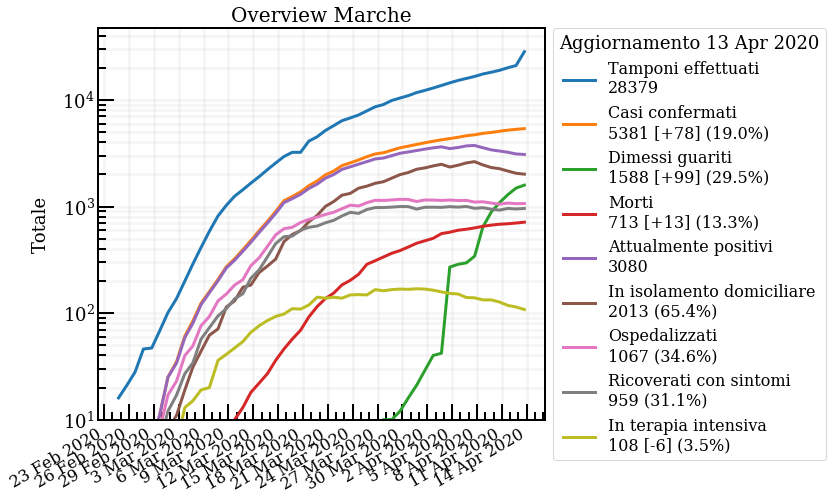

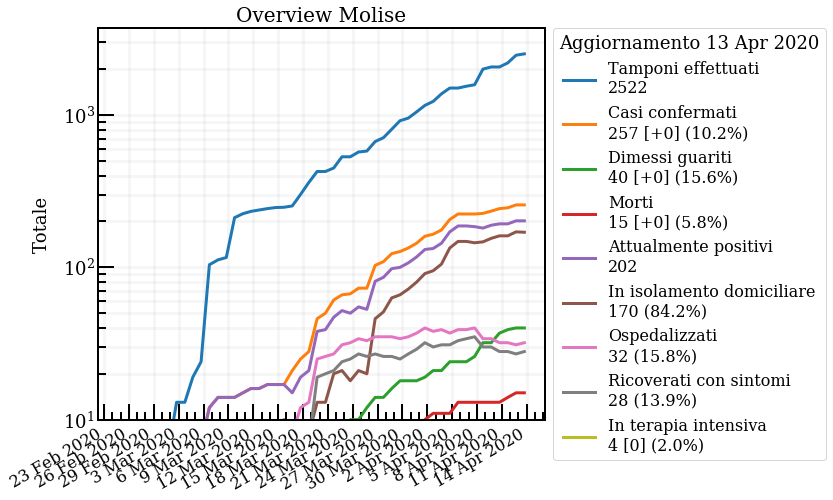

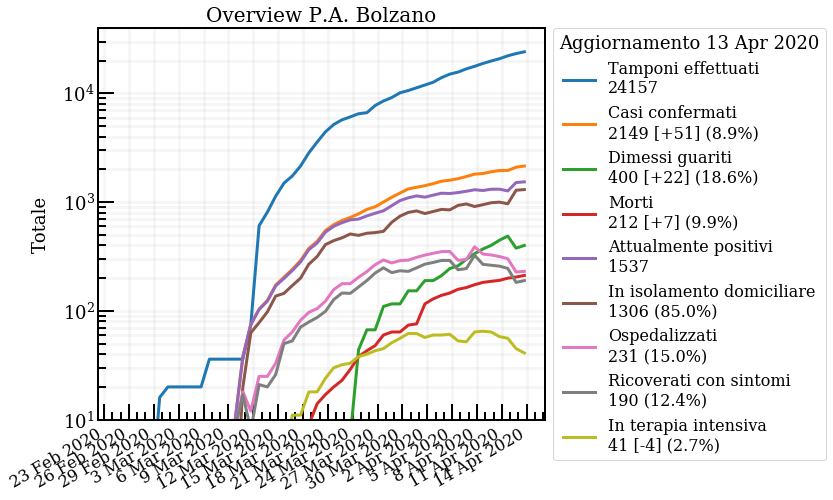

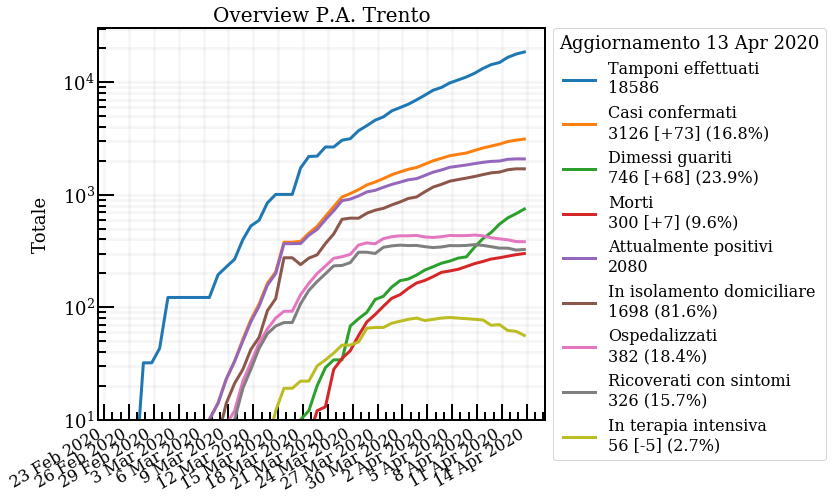

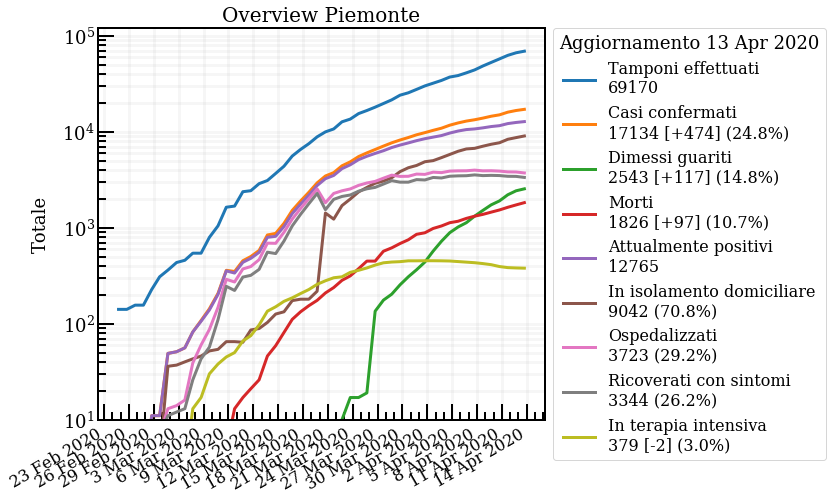

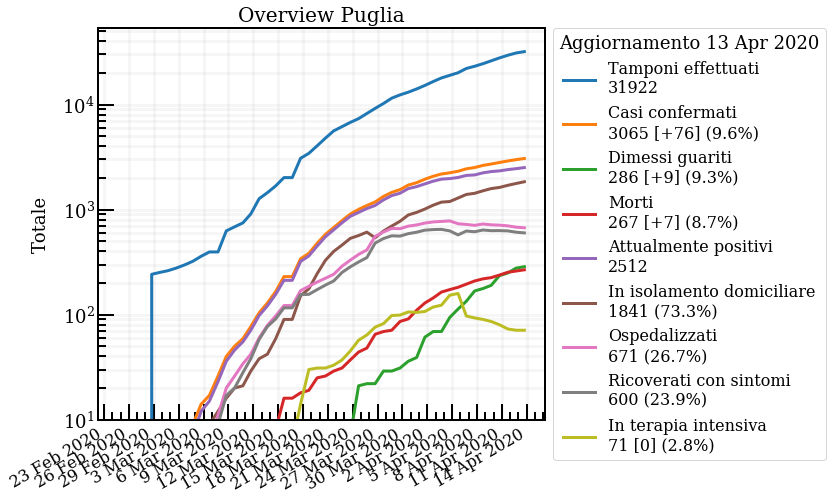

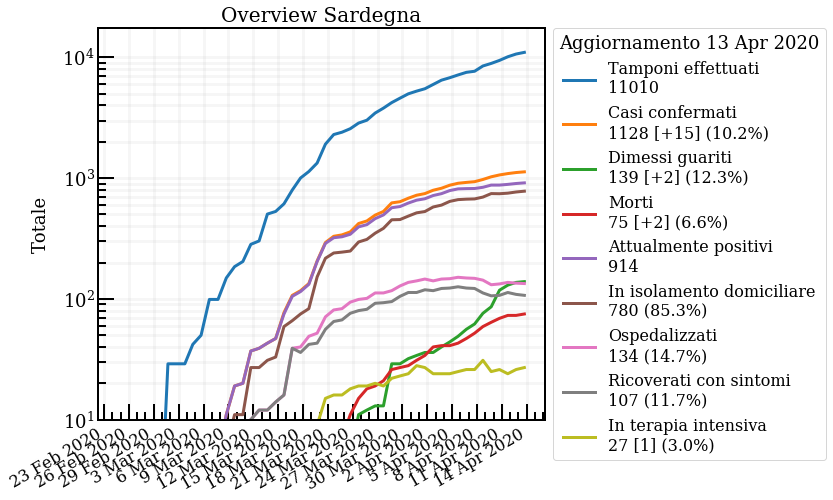

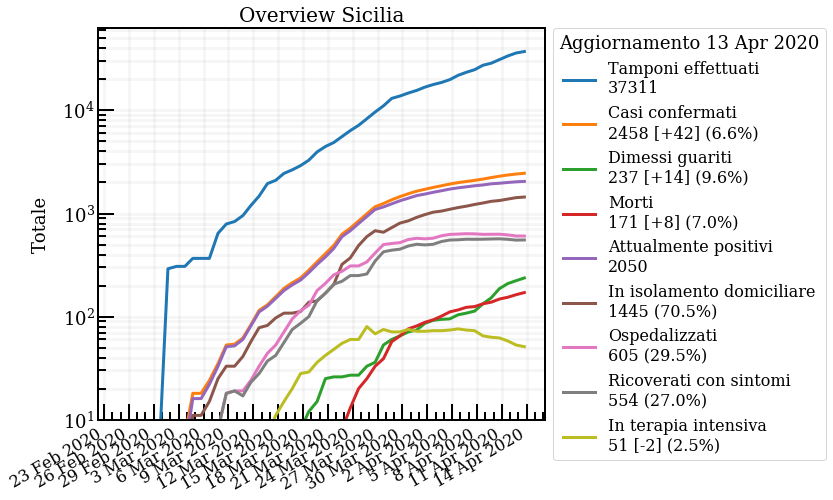

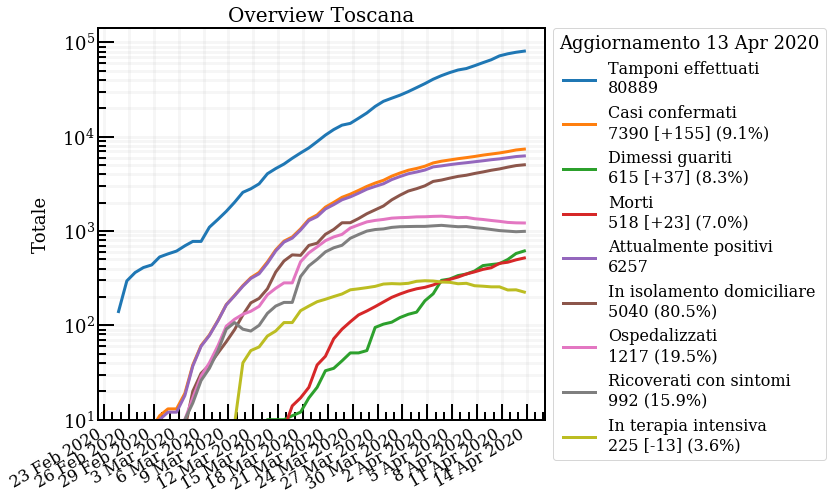

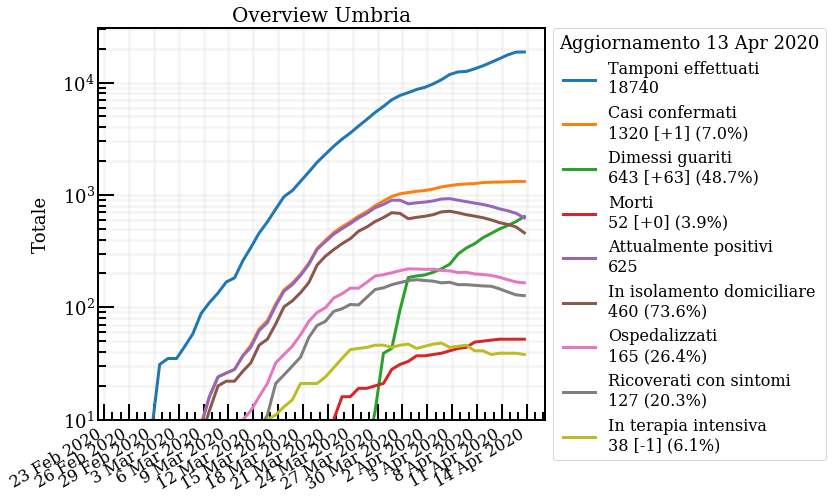

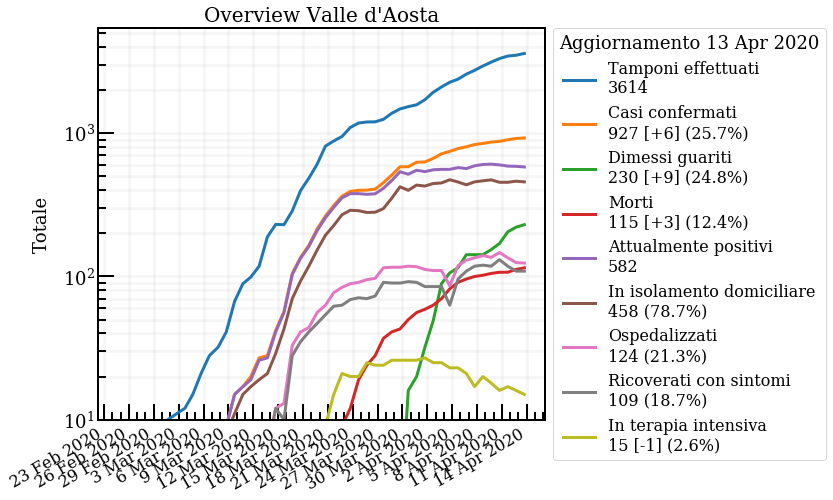

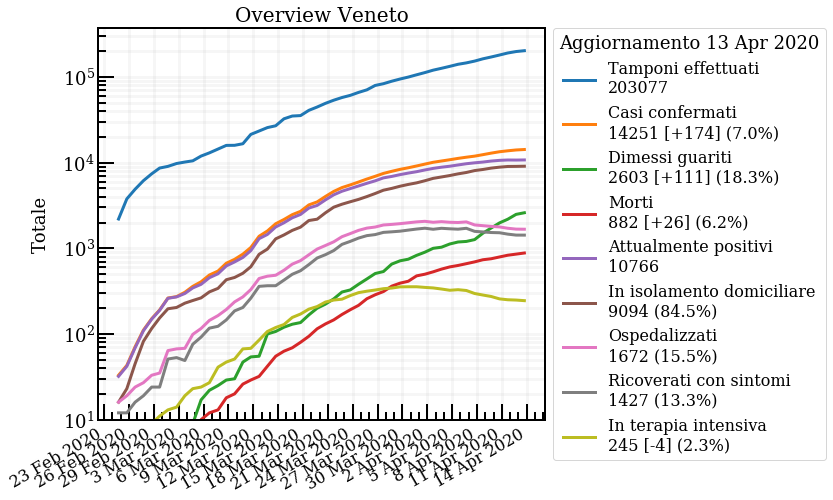

In [816]:
for regione in regioni['region'].unique():
    overview(regione, 'Overview '+regione)

# 2D Trail Plots
Tracciamento dell'evoluzione dei dati (due variabili) tramite scie di punti in grafici 2D.
L'evoluzione dei singoli parametri e' proiettata nei pannelli inferiore e sinistro.

**Come interpretare il grafico:**
* Punti piu' trasparenti corrispondono a giorni precedenti
* La coppia di valori alla data attuale e' mostrata da un punto colorato (zero trasparenza)
* Una maggiore distanza fra i punti (lungo uno degli assi o entrambi) indica una maggiore rapidita' di evoluzione del dato su base giornaliera.
* I valori numerici indicano il valore assoluto raggiunto e l'aumento giornaliero (tra parentesi).


## Casi confermati - Morti

In [817]:
def guideline(ax, xlim=(0,1), ylim=(0,1), m=1, label=''):
    xmin = xlim[0]
    xmax = xlim[1]
    ymin = ylim[0]
    ymax = ylim[1]
    ax.plot((0,1.5*xmax), (0,m*1.5*xmax), ls='--', lw=1, color='silver', zorder=-100)

    mplot = (ymax-ymin)/(xmax-xmin)
    if m < mplot:
        coord = [0.85*xmax, 0.85*xmax*m]
    else:
        coord = [0.85*ymax/m, 0.85*ymax]
    label = '%.f%s ' % (m*100, '%') + label
    ax.text(coord[0], coord[1], label, color='silver', fontsize=12, rotation=np.rad2deg(np.arctan(m/mplot*2/3)), ha='center', va='center', backgroundcolor='w', zorder=-100)

def trailplot(regions, ndays, varx, vary, title, xlabel, ylabel, guidelines, gl_label):
    sorted_df = data[data.region.isin(regions)][data.date==lastday].sort_values(varx+'_per100k')
    regions = sorted_df.region.unique()

    # Set up the axes with gridspec
    fig = plt.figure(figsize=(14,14))
    grid = plt.GridSpec(2, 3, hspace=0., wspace=0.)
    ax = fig.add_subplot(grid[:-1, 1:])
    y_ax = fig.add_subplot(grid[:-1, 0], xticks=[], sharey=ax)
    x_ax = fig.add_subplot(grid[-1, 1:], sharex=ax)
    x_ax.tick_params(axis='y', which='major', labelsize=14)

    # axes
    y_ax.set_ylabel(ylabel+' per 100 000 abitanti')
    x_ax.set_xlabel(xlabel+' per 100 000 abitanti')

    # plot curves
    days = np.arange(1,ndays)
    mk = 'o'
    ms=100
    #dummy points
    #x_ax.scatter(0,'',label='', color='w')
    y_ax.scatter('',0,label='', color='w')

    cmap = plt.get_cmap('nipy_spectral')
    for i,reg in enumerate(regions):
        color = cmap(i/len(regions))
        df = data[data.region==reg]

        for day in list(reversed(days)):
            x = df[varx+'_per100k'].iat[-day] # total value 'day' ago
            y = df[vary+'_per100k'].iat[-day]
            alpha = 1./day
            ax.scatter(x,y,label='', color=color, marker=mk, s=ms, alpha=alpha)
            x_ax.scatter(x,reg,label='', color=color, marker=mk, s=ms, alpha=alpha)
            y_ax.scatter(reg,y,label='', color=color, marker=mk, s=ms, alpha=alpha)
        #x_ax.text(x+0.03*xlim[1], reg, '%d (+%d)' % (df[varx].iat[-1], df['new_'+varx].iat[-1]), ha='left', va='center', fontsize=12)
        #y_ax.text(reg, y+0.03*ylim[1], '%d (+%d)' % (df[vary].iat[-1], df['new_'+vary].iat[-1]), ha='center', va='bottom', fontsize=10, rotation=90)

        
    # guidelines
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    x_ax.set_xlim(xlim)
    y_ax.set_ylim(ylim)
    
    for m in guidelines:
        guideline(ax=ax, xlim=xlim, ylim=ylim, m=m, label=gl_label)
        
    # disclaimer
    text = '© Copyright 2020, Pietro Di Gangi'
    x_ax.text(0.9*xlim[1], 0, text, rotation=90, verticalalignment='bottom', color='grey', fontsize=14)
    text = 'Dati COVID-19 del Dipartimento della Protezione Civile'
    x_ax.text(0.935*xlim[1], 0, text, rotation=90, verticalalignment='bottom', color='grey', fontsize=11)
    text = 'Dati popolazione italiana ISTAT (01/01/2019)'
    x_ax.text(0.96*xlim[1], 0, text, rotation=90, verticalalignment='bottom', color='grey', fontsize=11)

        
    #ax.grid(axis='x', linewidth=3, alpha=0.1, which='both')
    #x_ax.grid(axis='x', linewidth=3, alpha=0.1, which='both')
    #ax.grid(axis='y', linewidth=3, alpha=0.1, which='both')
    #y_ax.grid(axis='y', linewidth=3, alpha=0.1, which='both')

    ax.set_title(title + ' | Ultimi %d giorni (%s)' % (ndays, lastday.strftime('%-d %b %Y')), ha='center')

    plt.show()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


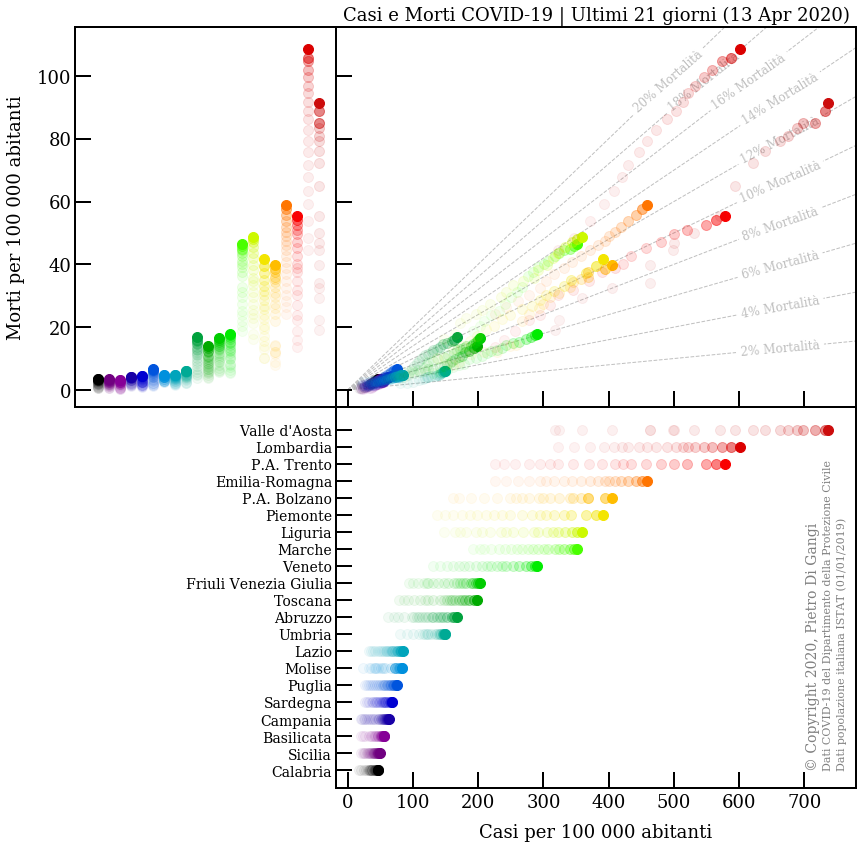

In [818]:
# Casi vs Morti
trailplot(regions=regioni.region.unique(), ndays=21,
          varx='cases', vary='deaths', title='Casi e Morti COVID-19', xlabel='Casi', ylabel='Morti',
          guidelines=[0.2,0.18,0.16,0.14,0.12,0.1,0.08,0.06,0.04,0.02], gl_label='Mortalità',
         )

## Tamponi effettuati - Casi di positivita' 

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


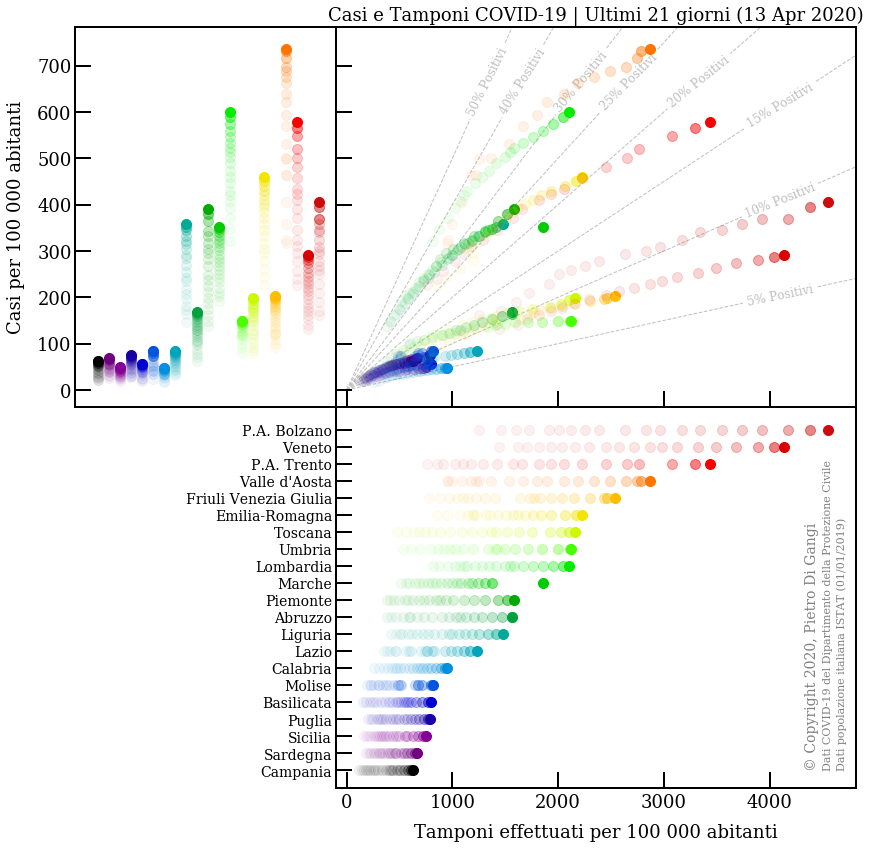

In [819]:
# Casi vs Tamponi
trailplot(regions=regioni.region.unique(), ndays=21,
          varx='tests', vary='cases', title='Casi e Tamponi COVID-19', ylabel='Casi', xlabel='Tamponi effettuati',
          guidelines=[0.5,0.4,0.3,0.25,0.2,0.15,0.1,0.05], gl_label='Positivi',
         )

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


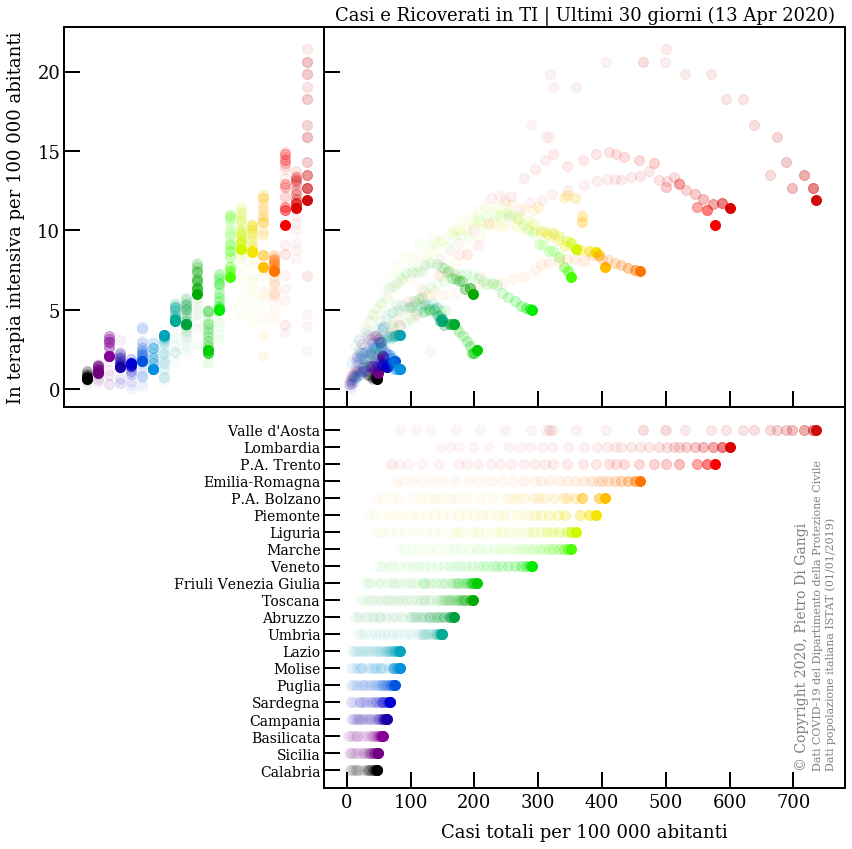

In [820]:
trailplot(regions=regioni.region.unique(), ndays=30,
          varx='cases', vary='terapia_intensiva', title='Casi e Ricoverati in TI', ylabel='In terapia intensiva', xlabel='Casi totali',
          guidelines=[], gl_label='',
         )

## Casi positivi - Casi in terapia intensiva
Evoluzione dei casi positivi (totale) e ricoveri in terapia intensiva (attuale) per regione.

**Effetto della neutralizzazione del virus:**
* Nessun avanzamento lungo l'asse dei casi totali
* Caduta dei punti verso lo zero dell'asse dei casi in terapia intensiva

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


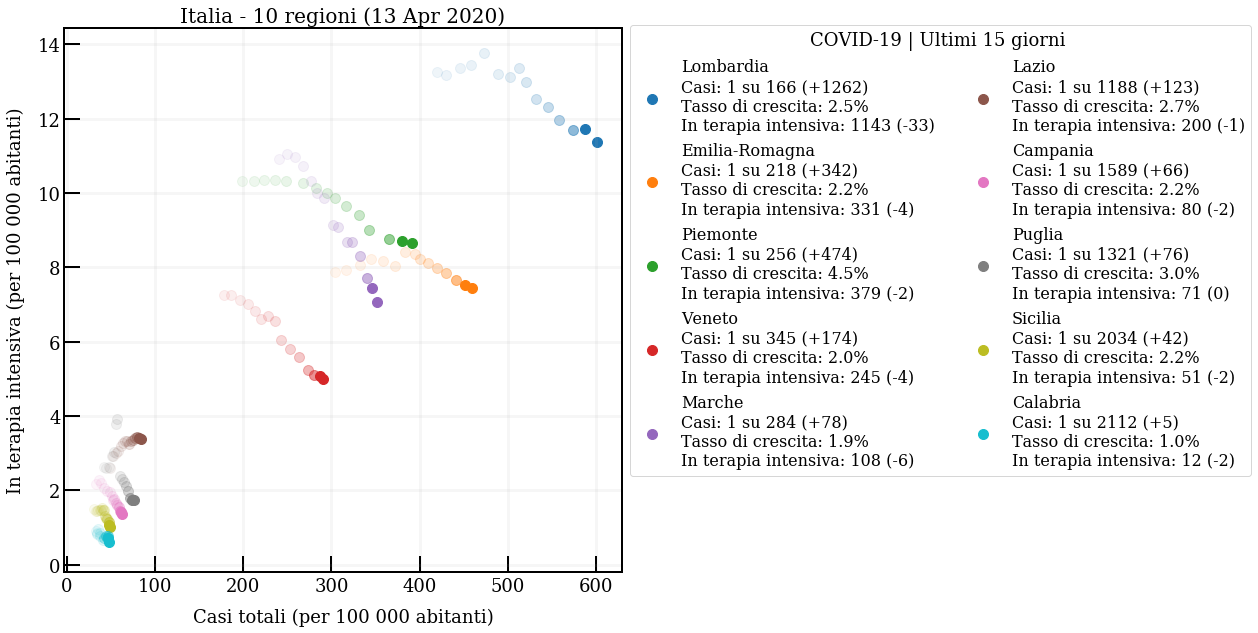

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


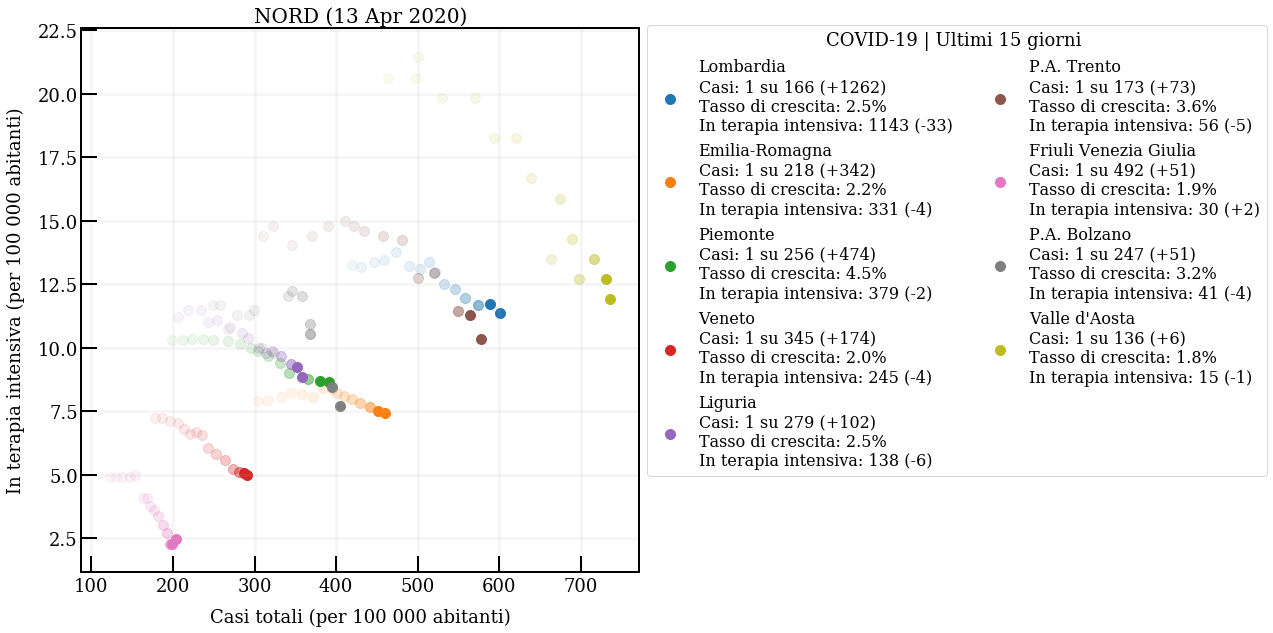

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


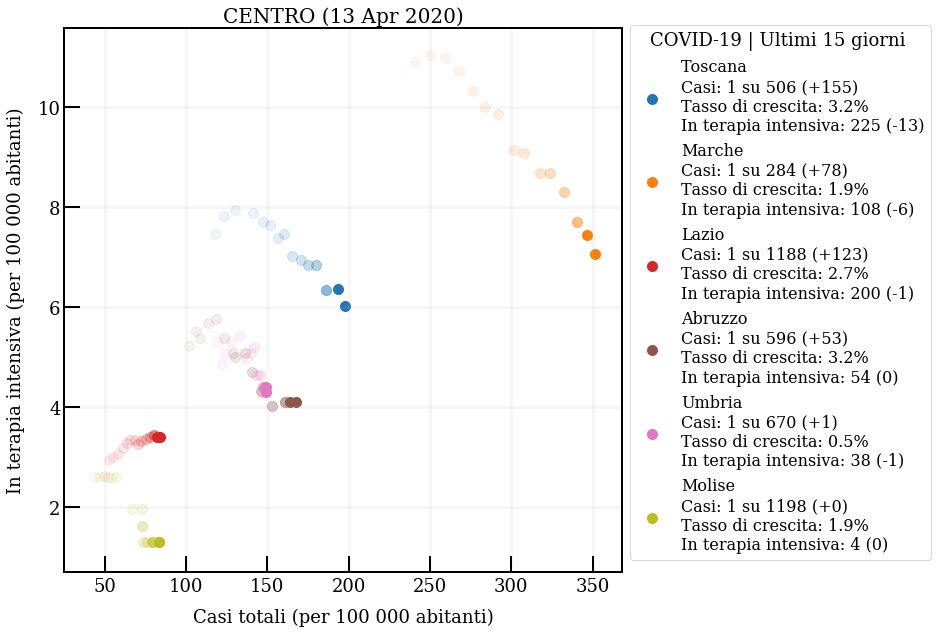

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


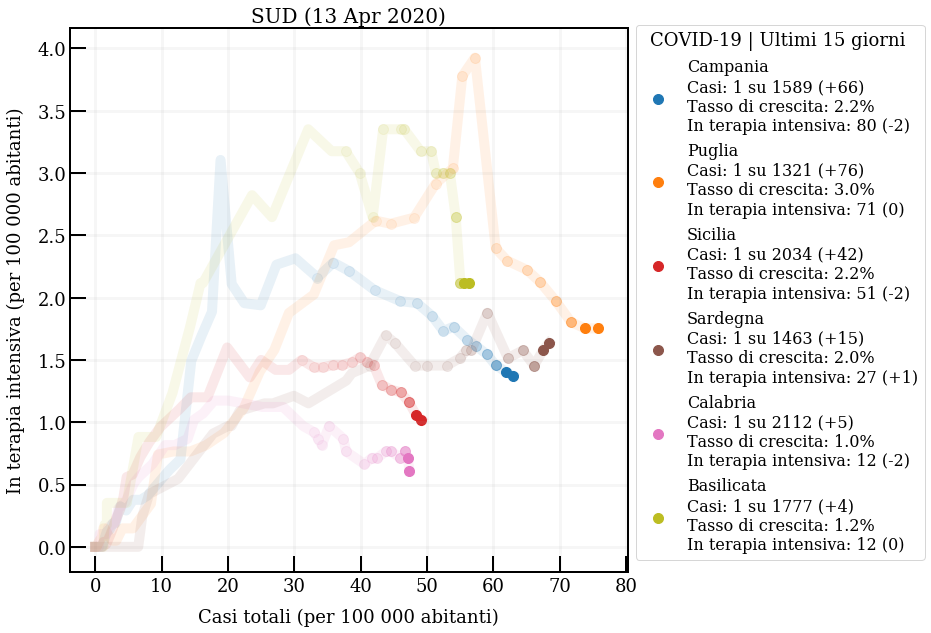

In [821]:
def pointevo_cases_icu(regions, dayspan, title='', line=False):
    vary = 'terapia_intensiva'
    varx = 'cases'
    regions = sorted_set(regions, 'cases')
    N = len(regions)
    cm = plt.get_cmap('tab10')

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)

    # plot curves
    ndays = dayspan
    days = np.arange(1,ndays)
    mk = 'o'
    ms=100

    for i,reg in enumerate(regions):
        df = data[data.region==reg]
        pop = df.population.iat[0]
        totx = df[varx].iat[-1]
        toty = df[vary].iat[-1]
        normalization = pop/1e5

        lb = '%s\nCasi: 1 su %.f (+%.f)' % (reg, pop/df.cases.iat[-1], df.new_cases.iat[-1])
        lb = lb + '\nTasso di crescita: %.1f%s' % (df.cases_delta3.iat[-1]*100, '%')
        sign = '+'
        if df.new_terapia_intensiva.iat[-1]<=0: sign=''
        lb = lb + '\nIn terapia intensiva: %d (%s%.f)' % (df.terapia_intensiva.iat[-1], sign, df.new_terapia_intensiva.iat[-1])
        if line:
            ax.plot(df[varx]/normalization, df[vary]/normalization, label='', color=cm(1.*i/N), lw=10, alpha=0.1)
        ax.scatter(df[varx].iat[-1]/normalization, df[vary].iat[-1]/normalization, label=lb, color=cm(1.*i/N), marker=mk, s=ms)

        for day in list(reversed(days)):
            x = df[varx].iat[-1-day]/normalization # total value 'day' ago
            y = df[vary].iat[-1-day]/normalization
            alpha = 1/day
            ax.scatter(x,y,label='', color=cm(1.*i/N), marker=mk, s=ms, alpha=alpha)

    plt.ylabel('In terapia intensiva (per 100 000 abitanti)')
    plt.xlabel('Casi totali (per 100 000 abitanti)')
    plt.grid(axis='x', linewidth=3, alpha=0.1, which='both')
    plt.grid(axis='y', linewidth=3, alpha=0.1, which='both')
    
    #plt.text(0, ax.get_ylim()[1]*0.95, title, fontsize=24, horizontalalignment='left')
    #legend
    leg = plt.legend(loc='upper left', ncol=int(N/7)+1, bbox_to_anchor=(1.,1.02), 
                     title='COVID-19 | Ultimi %d giorni ' % ndays)
    plt.title(title+' (%s)' % lastday.strftime('%-d %b %Y'), fontsize=20)

    plt.show()
    
    
regions = ['Lombardia', 'Emilia-Romagna', 'Marche', 'Piemonte', 'Veneto', 'Puglia', 'Lazio', 'Sicilia', 'Calabria', 'Campania']
pointevo_cases_icu(regions,15, 'Italia - 10 regioni', 0)
regions = nord
pointevo_cases_icu(regions,15, 'NORD', 0)
regions = centro
pointevo_cases_icu(regions,15, 'CENTRO', 0)
regions = sud
pointevo_cases_icu(regions,15, 'SUD', 1)